In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import learning_curve

In [2]:
# Define the start and end dates for data download
end_date = datetime.now()
start_date = datetime(2021, 4, 14)

# Download stock price data from Yahoo Finance using ticker 'COIN'
ticker = 'COIN'
data_coin = yf.download(tickers=ticker, start=start_date, end=end_date)
df_coin = pd.DataFrame(data_coin)
df_coin.reset_index(inplace=True)
df_coin.set_index('Date', inplace=True)

# Download gold prices and US Dollar index data from Yahoo Finance
tick_gold = 'GC=F'
tick_usindex = 'DX-Y.NYB'
data_gold = yf.download(tickers=tick_gold, start=start_date, end=end_date)
data_usindex = yf.download(tickers=tick_usindex, start=start_date, end=end_date)

# Convert downloaded data into dataframes
df_gold = pd.DataFrame(data_gold)
df_usindex = pd.DataFrame(data_usindex)

# Extract the adjusted close prices from gold and US Dollar index dataframes
df_coin['Gold_Adj_Close'] = df_gold['Adj Close']
df_coin['USIndex_Adj_Close'] = df_usindex['Adj Close']

# Forward fill missing values to align the data properly
df_coin = df_coin.ffill()

# Display the first few rows of the resulting dataframe
print(df_coin)

# Save the combined dataframe to a CSV file for future reference
df_coin.to_csv('coin_gold_usindex_data.csv')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-04-14  381.000000  429.540009  310.000000  328.279999  328.279999   
2021-04-15  348.899994  349.200012  317.269989  322.750000  322.750000   
2021-04-16  327.500000  345.989990  321.029999  342.000000  342.000000   
2021-04-19  337.260010  341.010010  326.790009  333.000000  333.000000   
2021-04-20  333.429993  334.829987  312.019989  320.820007  320.820007   
...                ...         ...         ...         ...         ...   
2024-06-17  239.869995  248.639999  234.229996  245.100006  245.100006   
2024-06-18  238.250000  242.800003  234.600006  235.949997  235.949997   
2024-06-20  237.360001  240.490005  228.440002  235.029999  235.029999   
2024-06-21  227.000000  228.250000  220.710007  225.860001  225.860001   
2024-06-24  217.050003  221.444000  207.720093  212.309998  212.309998   

              Volume  Gold_Adj_Close 

In [3]:
# Check for null values
df_coin.isnull().sum()

Open                 0
High                 0
Low                  0
Close                0
Adj Close            0
Volume               0
Gold_Adj_Close       0
USIndex_Adj_Close    0
dtype: int64

In [4]:
# Stats for data
df_coin.describe()

,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close
count,804.000000,804.000000,804.000000,804.000000,804.000000,8.040000e+02,804.000000,804.000000
mean,147.744490,152.466125,143.008843,147.558968,147.558968,1.113899e+07,1904.974872,101.392299
std,88.833601,90.773706,86.478670,88.402882,88.402882,8.511359e+06,163.640454,5.582884
min,32.580002,33.480000,31.549999,32.529999,32.529999,1.574700e+06,1623.300049,89.639999
25%,66.517500,69.557497,63.395001,66.727499,66.727499,5.405250e+06,1792.375031,96.290001
50%,124.025002,128.035004,118.660000,123.125000,123.125000,9.348700e+06,1871.349976,103.135002
75%,231.744999,238.695000,226.730000,232.217506,232.217506,1.407348e+07,1978.174988,105.012501
max,381.000000,429.540009,345.559998,357.390015,357.390015,8.106570e+07,2433.899902,114.110001


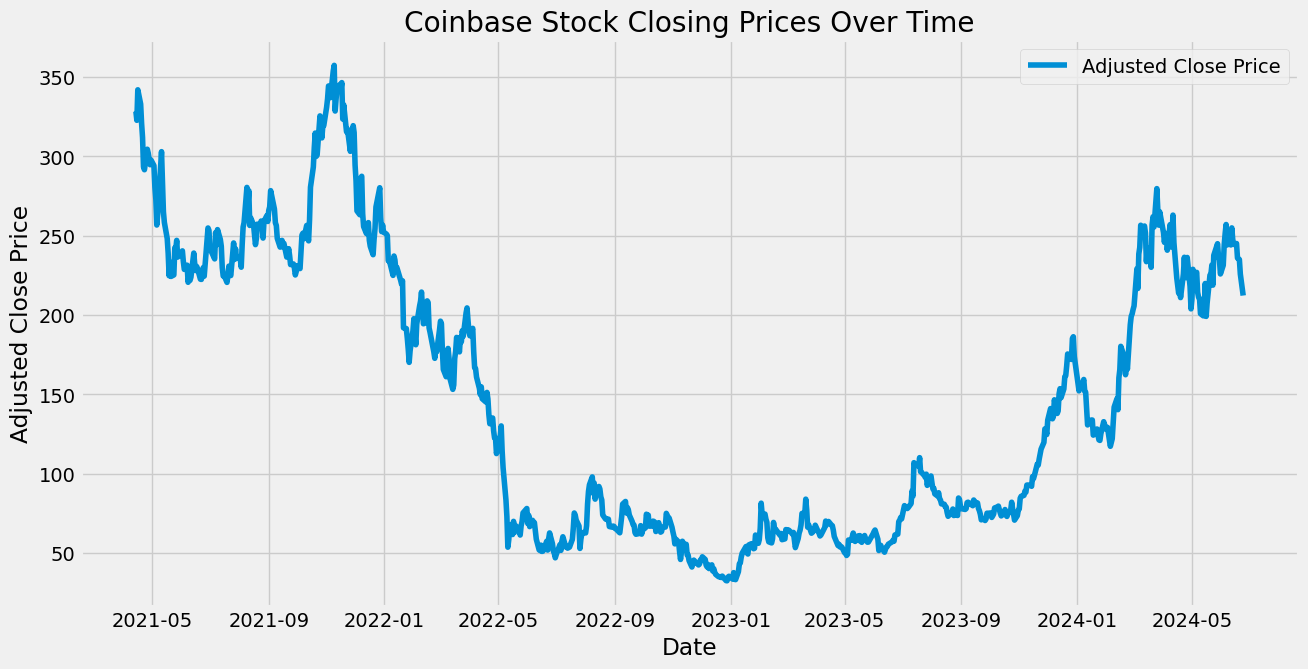

In [5]:
# Plotting the Adjusted Close price to show the trend
plt.style.use('fivethirtyeight')
plt.figure(figsize=(14, 7))
plt.plot(df_coin.index, df_coin['Adj Close'], label='Adjusted Close Price')
plt.title('Coinbase Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Calculate differences between open, high, low, and adjusted close prices for the stock data
df_coin['Open_Close_Diff'] = df_coin['Open'] - df_coin['Adj Close']
df_coin['High_Low_Diff'] = df_coin['High'] - df_coin['Low']

# Calculate percentage returns and log percentage returns
df_coin['Pct_Returns'] = df_coin['Adj Close'].pct_change()
df_coin['Log_Pct_Returns'] = np.log(1 + df_coin['Pct_Returns'])
df_coin.dropna(inplace=True)
df_coin

,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close,Open_Close_Diff,High_Low_Diff,Pct_Returns,Log_Pct_Returns
Date,,,,,,,,,,,,
2021-04-15,348.899994,349.200012,317.269989,322.750000,322.750000,39777900,1765.400024,91.669998,26.149994,31.930023,-0.016845,-0.016989
2021-04-16,327.500000,345.989990,321.029999,342.000000,342.000000,22654500,1779.000000,91.559998,-14.500000,24.959991,0.059644,0.057933
2021-04-19,337.260010,341.010010,326.790009,333.000000,333.000000,11405600,1769.400024,91.070000,4.260010,14.220001,-0.026316,-0.026668
2021-04-20,333.429993,334.829987,312.019989,320.820007,320.820007,18082300,1777.300049,91.239998,12.609985,22.809998,-0.036577,-0.037262
2021-04-21,312.519989,327.470001,302.100006,311.920013,311.920013,10103900,1792.300049,91.160004,0.599976,25.369995,-0.027741,-0.028133
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-17,239.869995,248.639999,234.229996,245.100006,245.100006,6662900,2312.399902,105.320000,-5.230011,14.410004,0.002454,0.002451
2024-06-18,238.250000,242.800003,234.600006,235.949997,235.949997,6198900,2330.399902,105.260002,2.300003,8.199997,-0.037332,-0.038046
2024-06-20,237.360001,240.490005,228.440002,235.029999,235.029999,6888900,2353.800049,105.589996,2.330002,12.050003,-0.003899,-0.003907


In [7]:
# List of columns to shift
columns_to_shift = [
    'Open', 'High', 'Adj Close', 'Low', 'Volume',
     'Open_Close_Diff', 'High_Low_Diff', 
     'Gold_Adj_Close', 'USIndex_Adj_Close'
]

# Number of lagged versions to create
num_lags = 3  

# Shift the columns
for column in columns_to_shift:
    for lag in range(1, num_lags + 1):
        df_coin[f'{column}_{lag}'] = df_coin[column].shift(lag)

df_coin['Pct_Returns_1'] = df_coin['Pct_Returns'].shift(1)
df_coin['Log_Pct_Returns_1'] = df_coin['Log_Pct_Returns'].shift(1)

df_coin.dropna(inplace=True)
df_coin

,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close,Open_Close_Diff,High_Low_Diff,...,High_Low_Diff_2,High_Low_Diff_3,Gold_Adj_Close_1,Gold_Adj_Close_2,Gold_Adj_Close_3,USIndex_Adj_Close_1,USIndex_Adj_Close_2,USIndex_Adj_Close_3,Pct_Returns_1,Log_Pct_Returns_1
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-20,333.429993,334.829987,312.019989,320.820007,320.820007,18082300,1777.300049,91.239998,12.609985,22.809998,...,24.959991,31.930023,1769.400024,1779.000000,1765.400024,91.070000,91.559998,91.669998,-0.026316,-0.026668
2021-04-21,312.519989,327.470001,302.100006,311.920013,311.920013,10103900,1792.300049,91.160004,0.599976,25.369995,...,14.220001,24.959991,1777.300049,1769.400024,1779.000000,91.239998,91.070000,91.559998,-0.036577,-0.037262
2021-04-22,305.760010,313.500000,287.200012,293.450012,293.450012,14991900,1781.199951,91.330002,12.309998,26.299988,...,22.809998,14.220001,1792.300049,1777.300049,1769.400024,91.160004,91.239998,91.070000,-0.027741,-0.028133
2021-04-23,282.750000,303.000000,282.070007,291.600006,291.600006,9853800,1777.000000,90.860001,-8.850006,20.929993,...,25.369995,22.809998,1781.199951,1792.300049,1777.300049,91.330002,91.160004,91.239998,-0.059214,-0.061039
2021-04-26,304.290009,306.100006,296.899994,304.540009,304.540009,6330200,1779.199951,90.809998,-0.250000,9.200012,...,26.299988,25.369995,1777.000000,1781.199951,1792.300049,90.860001,91.330002,91.160004,-0.006304,-0.006324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-17,239.869995,248.639999,234.229996,245.100006,245.100006,6662900,2312.399902,105.320000,-5.230011,14.410004,...,13.870010,12.680008,2331.399902,2300.199951,2336.000000,105.550003,105.199997,104.650002,-0.012680,-0.012761
2024-06-18,238.250000,242.800003,234.600006,235.949997,235.949997,6198900,2330.399902,105.260002,2.300003,8.199997,...,13.190002,13.870010,2312.399902,2331.399902,2300.199951,105.320000,105.550003,105.199997,0.002454,0.002451
2024-06-20,237.360001,240.490005,228.440002,235.029999,235.029999,6888900,2353.800049,105.589996,2.330002,12.050003,...,14.410004,13.190002,2330.399902,2312.399902,2331.399902,105.260002,105.320000,105.550003,-0.037332,-0.038046


Training MSE: 0.0007
Training MSE Std Dev: 0.0005
Test MSE: 0.0013
Test MSE Std Dev: 0.0012
Training RMSE: 0.0228
Training RMSE Std Dev: 0.0124
Test RMSE: 0.0313
Test RMSE Std Dev: 0.0172
Training MAE: 0.0159
Training MAE Std Dev: 0.0089
Test MAE: 0.0232
Test MAE Std Dev: 0.0132
Training R2: 0.7946
Training R2 Std Dev: 0.1310
Test R2: 0.6868
Test R2 Std Dev: 0.1867


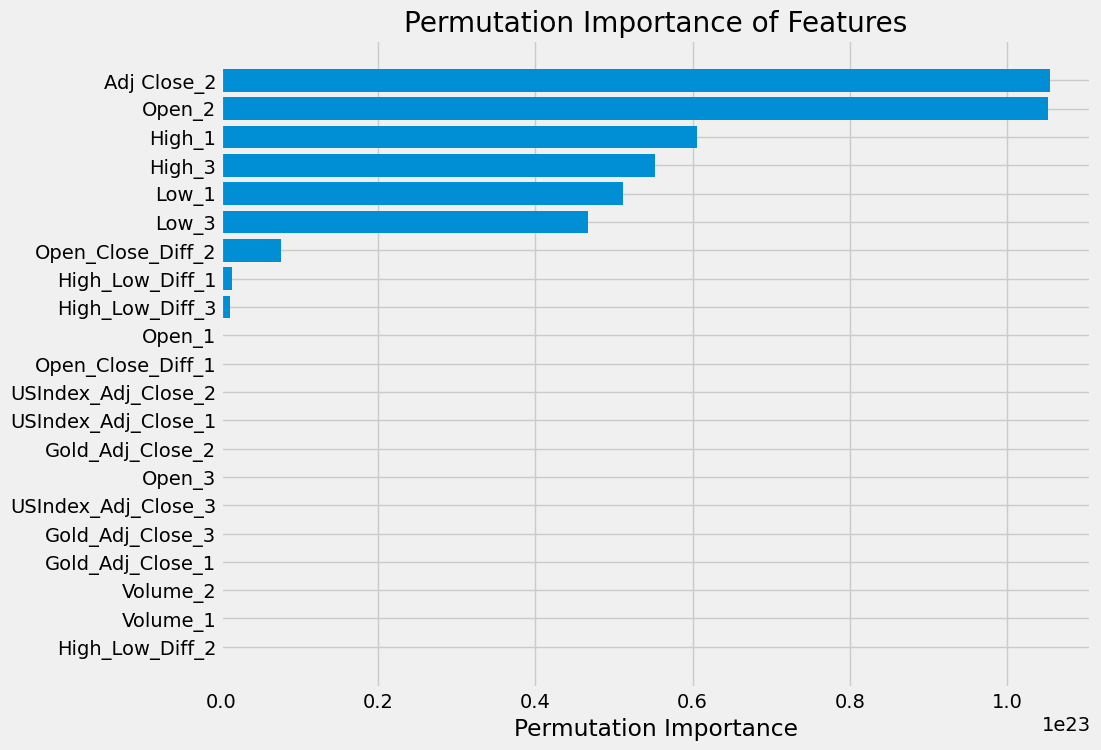

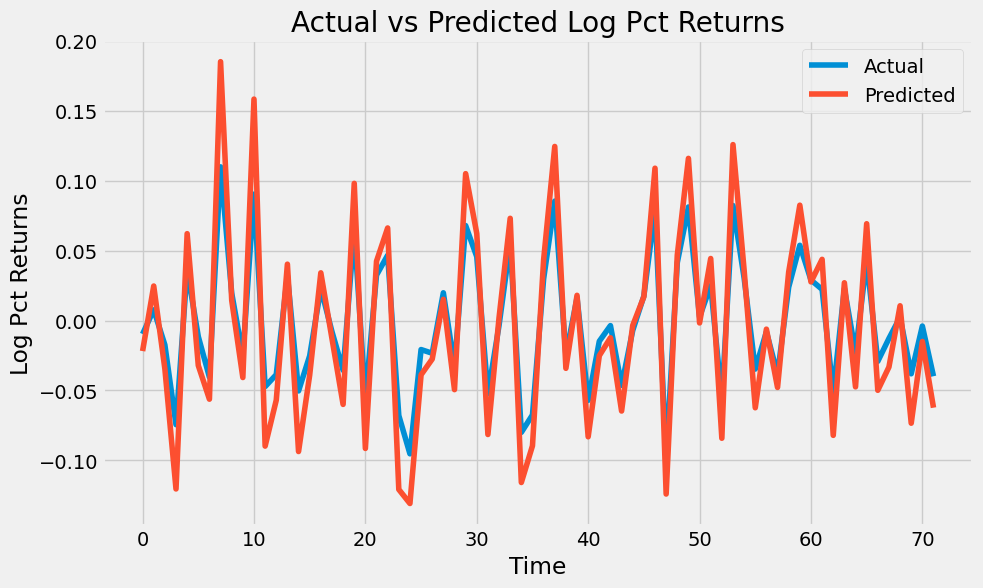

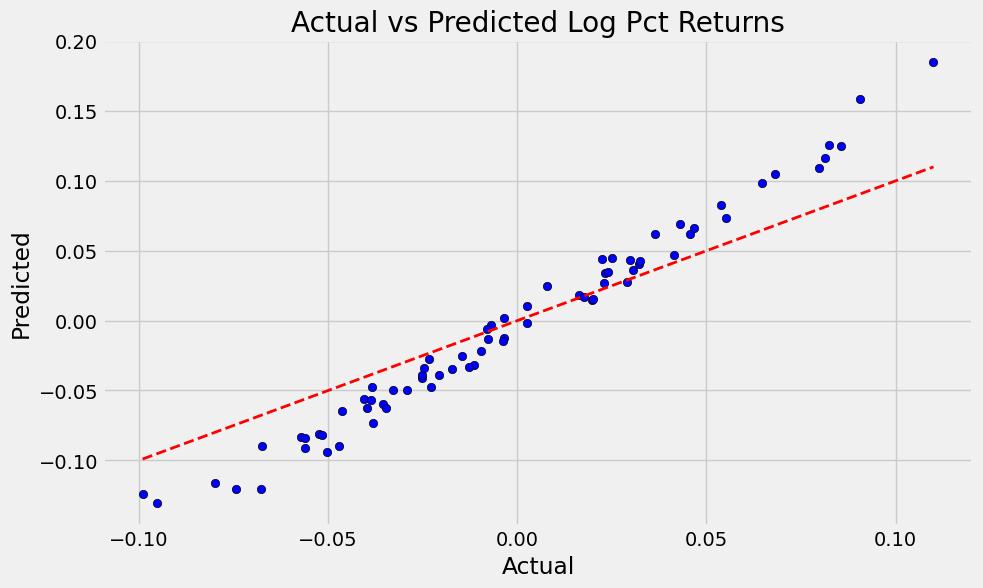

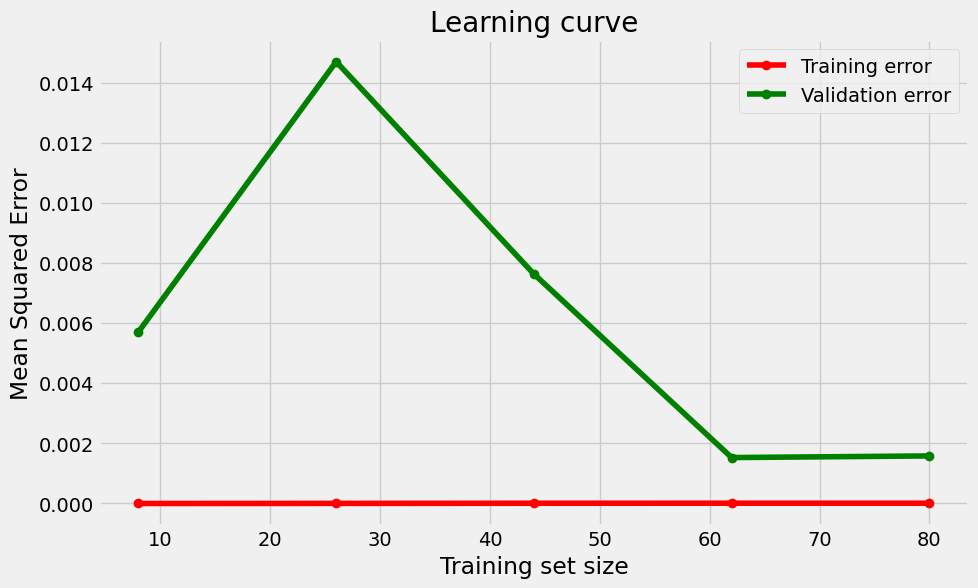

In [8]:
# Best performing model on raw data 
# among Linear, Lasso, Ridge, Random Forest, Gradient Boost, XGBoost and SVR is Linear Regression model

# Linear Regression
features = ['Volume_1', 'Open_1', 'High_1', 'Low_1',
            'Open_Close_Diff_1','High_Low_Diff_1', 'Gold_Adj_Close_1','USIndex_Adj_Close_1',
            'Volume_2', 'Open_2', 'Adj Close_2',
            'Open_Close_Diff_2','High_Low_Diff_2', 'Gold_Adj_Close_2','USIndex_Adj_Close_2',
             'Open_3', 'High_3', 'Low_3',
            'High_Low_Diff_3', 'Gold_Adj_Close_3','USIndex_Adj_Close_3'
            ]
X = df_coin[features].dropna()
y = df_coin['Log_Pct_Returns_1'][X.index]

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Initialize model
model = LinearRegression()

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Initialize lists to store metrics
train_mse_scores = []
test_mse_scores = []
train_rmse_scores = []
test_rmse_scores = []
train_mae_scores = []
test_mae_scores = []
train_r2_scores = []
test_r2_scores = []
perm_imp_scores = []

# Perform cross-validation
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model
    model.fit(X_train, y_train)

    # Calculate permutation importance
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    perm_imp = result.importances_mean
    perm_imp_scores.append(perm_imp)
    
    # Predict on the test set
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate performance metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Append metrics to lists
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)
    train_mae_scores.append(train_mae)
    test_mae_scores.append(test_mae)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Calculate mean and standard deviation of the scores
mean_train_mse = np.mean(train_mse_scores)
std_train_mse = np.std(train_mse_scores)
mean_test_mse = np.mean(test_mse_scores)
std_test_mse = np.std(test_mse_scores)
mean_train_rmse = np.mean(train_rmse_scores)
std_train_rmse = np.std(train_rmse_scores)
mean_test_rmse = np.mean(test_rmse_scores)
std_test_rmse = np.std(test_rmse_scores)
mean_train_mae = np.mean(train_mae_scores)
std_train_mae = np.std(train_mae_scores)
mean_test_mae = np.mean(test_mae_scores)
std_test_mae = np.std(test_mae_scores)
mean_train_r2 = np.mean(train_r2_scores)
std_train_r2 = np.std(train_r2_scores)
mean_test_r2 = np.mean(test_r2_scores)
std_test_r2 = np.std(test_r2_scores)

# Calculate mean permutation importance across all folds
mean_perm_imp = np.mean(perm_imp_scores, axis=0)

# Print Results
print("Training MSE: {:.4f}".format(mean_train_mse))
print("Training MSE Std Dev: {:.4f}".format(std_train_mse))
print("Test MSE: {:.4f}".format(mean_test_mse))
print("Test MSE Std Dev: {:.4f}".format(std_test_mse))
print("Training RMSE: {:.4f}".format(mean_train_rmse))
print("Training RMSE Std Dev: {:.4f}".format(std_train_rmse))
print("Test RMSE: {:.4f}".format(mean_test_rmse))
print("Test RMSE Std Dev: {:.4f}".format(std_test_rmse))
print("Training MAE: {:.4f}".format(mean_train_mae))
print("Training MAE Std Dev: {:.4f}".format(std_train_mae))
print("Test MAE: {:.4f}".format(mean_test_mae))
print("Test MAE Std Dev: {:.4f}".format(std_test_mae))
print("Training R2: {:.4f}".format(mean_train_r2))
print("Training R2 Std Dev: {:.4f}".format(std_train_r2))
print("Test R2: {:.4f}".format(mean_test_r2))
print("Test R2 Std Dev: {:.4f}".format(std_test_r2))

# Visualize permutation importance
feature_names = X.columns
sorted_idx = mean_perm_imp.argsort()

plt.figure(figsize=(10, 8))
plt.barh(feature_names[sorted_idx], mean_perm_imp[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance of Features')
plt.show()

# Visualize model performance
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Log Pct Returns')
plt.title('Actual vs Predicted Log Pct Returns')
plt.legend()
plt.show()

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, c='blue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Log Pct Returns')
plt.show()

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(model, X_scaled, y, cv=tscv, scoring='neg_mean_squared_error')
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training set size')
plt.ylabel('Mean Squared Error')
plt.title('Learning curve')
plt.legend(loc='best')
plt.show()

In [9]:
# Defining features for models
features = ['Volume_1', 'Open_1', 'High_1', 'Low_1','Adj Close_1',
            'Open_Close_Diff_1','High_Low_Diff_1', 'Gold_Adj_Close_1','USIndex_Adj_Close_1',
            'Volume_2', 'Open_2', 'High_2', 'Low_2','Adj Close_2',
            'Open_Close_Diff_2','High_Low_Diff_2', 'Gold_Adj_Close_2','USIndex_Adj_Close_2',
            'Volume_3', 'Open_3', 'High_3', 'Low_3','Adj Close_3',
            'Open_Close_Diff_3','High_Low_Diff_3', 'Gold_Adj_Close_3','USIndex_Adj_Close_3'
            ]
X = df_coin[features].dropna()
y = df_coin['Log_Pct_Returns_1'][X.index]

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# Define models to evaluate
models = {
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boost": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(objective='reg:squarederror'),
    "SVR": SVR(kernel='linear')
}

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Initialize dictionary to store results
results = {}

# Evaluate each model
for name, model in models.items():
    train_mse_scores, test_mse_scores = [], []
    train_rmse_scores, test_rmse_scores = [], []
    train_mae_scores, test_mae_scores = [], []
    train_r2_scores, test_r2_scores = [], []
    
    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        train_mse_scores.append(mean_squared_error(y_train, y_train_pred))
        test_mse_scores.append(mean_squared_error(y_test, y_test_pred))
        train_rmse_scores.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
        test_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
        train_mae_scores.append(mean_absolute_error(y_train, y_train_pred))
        test_mae_scores.append(mean_absolute_error(y_test, y_test_pred))
        train_r2_scores.append(r2_score(y_train, y_train_pred))
        test_r2_scores.append(r2_score(y_test, y_test_pred))
    
    results[name] = {
        "Training MSE": (np.mean(train_mse_scores), np.std(train_mse_scores)),
        "Test MSE": (np.mean(test_mse_scores), np.std(test_mse_scores)),
        "Training RMSE": (np.mean(train_rmse_scores), np.std(train_rmse_scores)),
        "Test RMSE": (np.mean(test_rmse_scores), np.std(test_rmse_scores)),
        "Training MAE": (np.mean(train_mae_scores), np.std(train_mae_scores)),
        "Test MAE": (np.mean(test_mae_scores), np.std(test_mae_scores)),
        "Training R2": (np.mean(train_r2_scores), np.std(train_r2_scores)),
        "Test R2": (np.mean(test_r2_scores), np.std(test_r2_scores))
    }

# Print results for each model
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric_name, (mean_value, std_dev) in metrics.items():
        print(f"{metric_name}: {mean_value:.4f} (Std Dev: {std_dev:.4f})")



Lasso:
Training MSE: 0.0027 (Std Dev: 0.0009)
Test MSE: 0.0033 (Std Dev: 0.0017)
Training RMSE: 0.0513 (Std Dev: 0.0091)
Test RMSE: 0.0558 (Std Dev: 0.0150)
Training MAE: 0.0386 (Std Dev: 0.0061)
Test MAE: 0.0434 (Std Dev: 0.0114)
Training R2: 0.0000 (Std Dev: 0.0000)
Test R2: -0.0264 (Std Dev: 0.0205)

Ridge:
Training MSE: 0.0012 (Std Dev: 0.0005)
Test MSE: 0.0019 (Std Dev: 0.0015)
Training RMSE: 0.0335 (Std Dev: 0.0082)
Test RMSE: 0.0396 (Std Dev: 0.0170)
Training MAE: 0.0234 (Std Dev: 0.0050)
Test MAE: 0.0299 (Std Dev: 0.0124)
Training R2: 0.5799 (Std Dev: 0.0707)
Test R2: 0.5021 (Std Dev: 0.1792)

Random Forest:
Training MSE: 0.0002 (Std Dev: 0.0001)
Test MSE: 0.0017 (Std Dev: 0.0011)
Training RMSE: 0.0127 (Std Dev: 0.0024)
Test RMSE: 0.0397 (Std Dev: 0.0132)
Training MAE: 0.0083 (Std Dev: 0.0010)
Test MAE: 0.0280 (Std Dev: 0.0084)
Training R2: 0.9384 (Std Dev: 0.0096)
Test R2: 0.4821 (Std Dev: 0.1307)

Gradient Boost:
Training MSE: 0.0002 (Std Dev: 0.0001)
Test MSE: 0.0017 (Std D

##### Technical Indicators

In [10]:
# Moving Averages

# Simple Moving Averages
df_coin['SMA_5'] = df_coin['Adj Close'].rolling(window=5).mean()
df_coin['SMA_10'] = df_coin['Adj Close'].rolling(window=10).mean()
df_coin['SMA_20'] = df_coin['Adj Close'].rolling(window=20).mean()
df_coin['SMA_50'] = df_coin['Adj Close'].rolling(window=50).mean()

# Exponential Moving Averages
df_coin['EMA_50'] = df_coin['Adj Close'].ewm(span=50, adjust=False).mean()

# Relative Strength Index (RSI)
window_length = 14
delta = df_coin['Adj Close'].diff()
gain = (delta.where(delta>0, 0)).rolling(window=window_length).mean()
loss = (delta.where(delta<0, 0)).rolling(window=window_length).mean()
rs = gain/loss
df_coin['RSI'] = 100 - (100/(1+rs))

# Moving Average Convergence Divergence (MACD)
df_coin['MACD'] = df_coin['Adj Close'].ewm(span=12, adjust=False).mean() - df_coin['Adj Close'].ewm(span=26, adjust=False).mean()
df_coin['MACD_Signal'] = df_coin['MACD'].ewm(span=9, adjust=False).mean()
df_coin['MACD_Hist'] = df_coin['MACD'] - df_coin['MACD_Signal']

# Bollinger Bands
df_coin['BB_Upper'] = df_coin['SMA_20'] + 2*df_coin['Adj Close'].rolling(window=20).std()
df_coin['BB_Lower'] = df_coin['SMA_20'] - 2*df_coin['Adj Close'].rolling(window=20).std()

# Stochastic Oscillator
df_coin['14-high'] = df_coin['High'].rolling(14).max()
df_coin['14-low'] = df_coin['Low'].rolling(14).min()
df_coin['%K'] = (df_coin['Adj Close'] - df_coin['14-low']) * 100 / (df_coin['14-high'] - df_coin['14-low'])
df_coin['%D'] = df_coin['%K'].rolling(3).mean()

# Average True Range (ATR)
df_coin['H-L'] = df_coin['High'] - df_coin['Low']
df_coin['H-PC'] = np.abs(df_coin['High'] - df_coin['Adj Close'].shift(1))
df_coin['L-PC'] = np.abs(df_coin['Low'] - df_coin['Adj Close'].shift(1))
df_coin['TR'] = df_coin[['H-L', 'H-PC', 'L-PC']].max(axis=1)
df_coin['ATR'] = df_coin['TR'].rolling(14).mean()

df_coin

,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close,Open_Close_Diff,High_Low_Diff,...,BB_Lower,14-high,14-low,%K,%D,H-L,H-PC,L-PC,TR,ATR
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-20,333.429993,334.829987,312.019989,320.820007,320.820007,18082300,1777.300049,91.239998,12.609985,22.809998,...,NaN,NaN,NaN,NaN,NaN,22.809998,NaN,NaN,22.809998,NaN
2021-04-21,312.519989,327.470001,302.100006,311.920013,311.920013,10103900,1792.300049,91.160004,0.599976,25.369995,...,NaN,NaN,NaN,NaN,NaN,25.369995,6.649994,18.720001,25.369995,NaN
2021-04-22,305.760010,313.500000,287.200012,293.450012,293.450012,14991900,1781.199951,91.330002,12.309998,26.299988,...,NaN,NaN,NaN,NaN,NaN,26.299988,1.579987,24.720001,26.299988,NaN
2021-04-23,282.750000,303.000000,282.070007,291.600006,291.600006,9853800,1777.000000,90.860001,-8.850006,20.929993,...,NaN,NaN,NaN,NaN,NaN,20.929993,9.549988,11.380005,20.929993,NaN
2021-04-26,304.290009,306.100006,296.899994,304.540009,304.540009,6330200,1779.199951,90.809998,-0.250000,9.200012,...,NaN,NaN,NaN,NaN,NaN,9.200012,14.500000,5.299988,14.500000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-17,239.869995,248.639999,234.229996,245.100006,245.100006,6662900,2312.399902,105.320000,-5.230011,14.410004,...,218.364226,263.799988,219.169998,58.099964,59.548905,14.410004,4.139999,10.270004,14.410004,15.414286
2024-06-18,238.250000,242.800003,234.600006,235.949997,235.949997,6198900,2330.399902,105.260002,2.300003,8.199997,...,219.929995,263.799988,219.169998,37.598034,50.817854,8.199997,2.300003,10.500000,10.500000,15.320000
2024-06-20,237.360001,240.490005,228.440002,235.029999,235.029999,6888900,2353.800049,105.589996,2.330002,12.050003,...,221.386009,263.799988,219.169998,35.536644,43.744881,12.050003,4.540009,7.509995,12.050003,15.075000


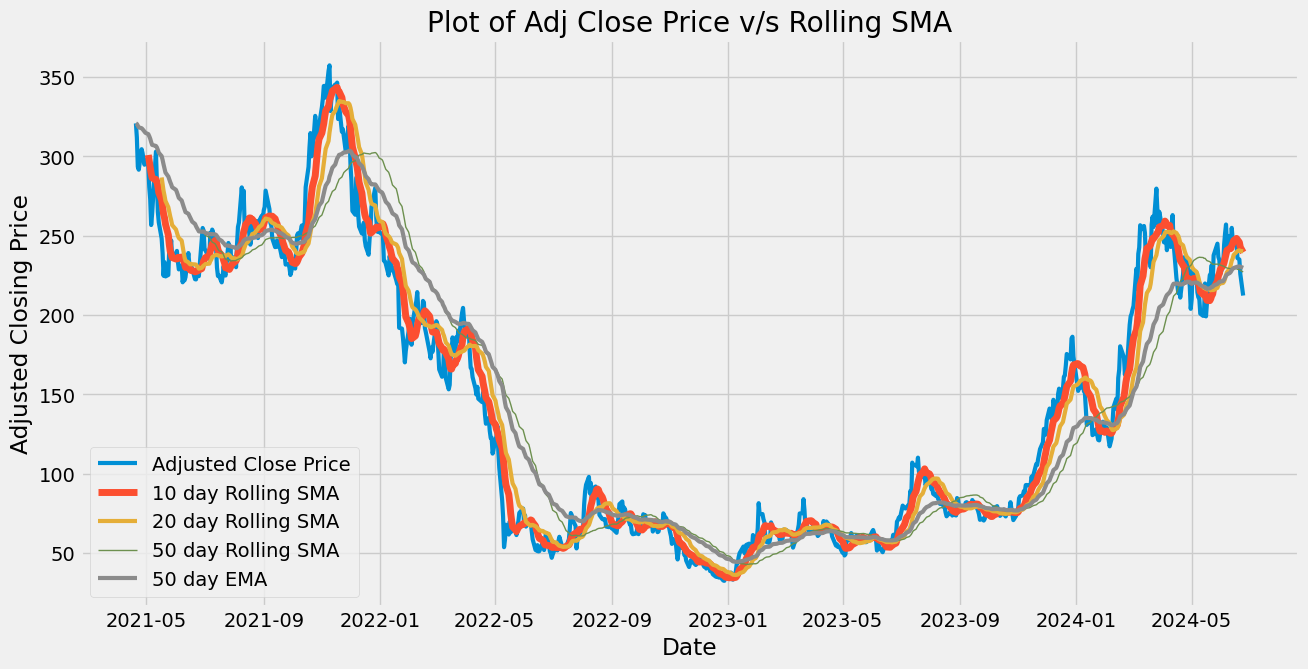

In [11]:
#Plotting 'Adj Close' Price and Rolling SMA and EMA lines
plt.figure(figsize = (14,7))
plt.plot(df_coin['Adj Close'],label='Adjusted Close Price',linewidth=3)
plt.plot(df_coin['SMA_10'],label='10 day Rolling SMA',linewidth=5)
plt.plot(df_coin['SMA_20'],label='20 day Rolling SMA',linewidth=3)
plt.plot(df_coin['SMA_50'],label='50 day Rolling SMA',linewidth=1)
plt.plot(df_coin['EMA_50'],label='50 day EMA',linewidth=3)
plt.xlabel('Date')
plt.ylabel('Adjusted Closing Price')
plt.title('Plot of Adj Close Price v/s Rolling SMA')
plt.legend()

In [12]:
# List of columns to shift
columns_to_shift = [
    'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50', 'EMA_50', 'RSI', 'MACD', 'MACD_Signal', 
    'MACD_Hist', 'BB_Upper', 'BB_Lower', '%K', '%D', 'ATR'
]

# Number of lagged versions to create
num_lags = 2

# Shift the columns
for column in columns_to_shift:
    for lag in range(1, num_lags + 1):
        df_coin[f'{column}_{lag}'] = df_coin[column].shift(lag)

df_coin.dropna(inplace=True)
df_coin


,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close,Open_Close_Diff,High_Low_Diff,...,BB_Upper_1,BB_Upper_2,BB_Lower_1,BB_Lower_2,%K_1,%K_2,%D_1,%D_2,ATR_1,ATR_2
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-01,251.089996,255.149994,240.529999,241.440002,241.440002,3611300,1775.900024,92.599998,9.649994,14.619995,...,251.226162,248.297110,211.213839,212.860890,84.418435,87.594281,89.446274,77.139834,9.779282,9.809281
2021-07-02,242.000000,246.800003,238.880005,240.720001,240.720001,2325000,1782.599976,92.230003,1.279999,7.919998,...,252.111320,251.226162,211.106681,211.213839,60.877341,84.418435,77.630019,89.446274,10.545710,9.779282
2021-07-06,243.000000,243.000000,234.020004,235.410004,235.410004,2212600,1793.500000,92.550003,7.589996,8.979996,...,253.053757,252.111320,211.357244,211.106681,59.448200,60.877341,68.247992,77.630019,9.979996,10.545710
2021-07-07,238.960007,252.990005,232.339996,251.970001,251.970001,4804400,1801.500000,92.639999,-13.009995,20.650009,...,253.296716,253.053757,211.510286,211.357244,48.908306,59.448200,56.411282,68.247992,10.039995,9.979996
2021-07-08,239.000000,246.600006,233.610001,244.289993,244.289993,4350000,1799.599976,92.360001,-5.289993,12.990005,...,255.827026,253.296716,212.110976,211.510286,81.778494,48.908306,63.378333,56.411282,10.914997,10.039995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-17,239.869995,248.639999,234.229996,245.100006,245.100006,6662900,2312.399902,105.320000,-5.230011,14.410004,...,263.532409,266.331908,212.293588,204.961088,56.755563,63.791189,67.129235,67.384246,15.533572,15.943571
2024-06-18,238.250000,242.800003,234.600006,235.949997,235.949997,6198900,2330.399902,105.260002,2.300003,8.199997,...,261.211770,263.532409,218.364226,212.293588,58.099964,56.755563,59.548905,67.129235,15.414286,15.533572
2024-06-20,237.360001,240.490005,228.440002,235.029999,235.029999,6888900,2353.800049,105.589996,2.330002,12.050003,...,260.722001,261.211770,219.929995,218.364226,37.598034,58.099964,50.817854,59.548905,15.320000,15.414286


Training MSE: 0.0006
Training MSE Std Dev: 0.0004
Test MSE: 0.0011
Test MSE Std Dev: 0.0012
Training RMSE: 0.0221
Training RMSE Std Dev: 0.0107
Test RMSE: 0.0295
Test RMSE Std Dev: 0.0156
Training MAE: 0.0157
Training MAE Std Dev: 0.0075
Test MAE: 0.0224
Test MAE Std Dev: 0.0124
Training R2: 0.8263
Training R2 Std Dev: 0.0965
Test R2: 0.7326
Test R2 Std Dev: 0.1362


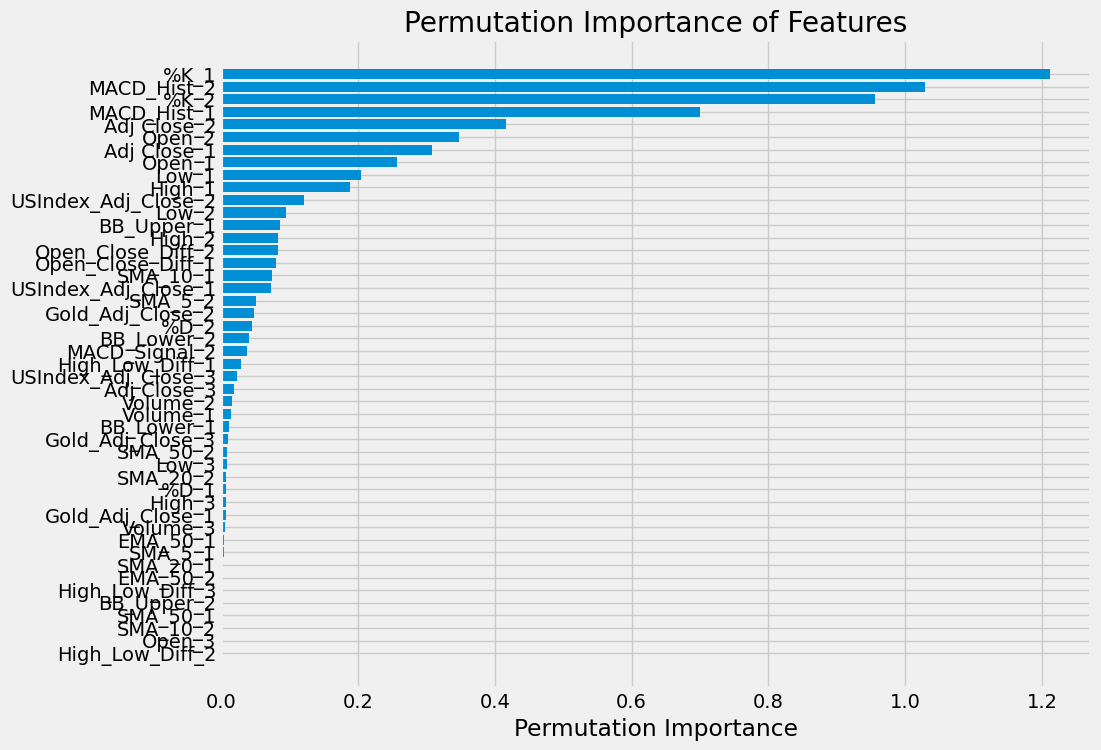

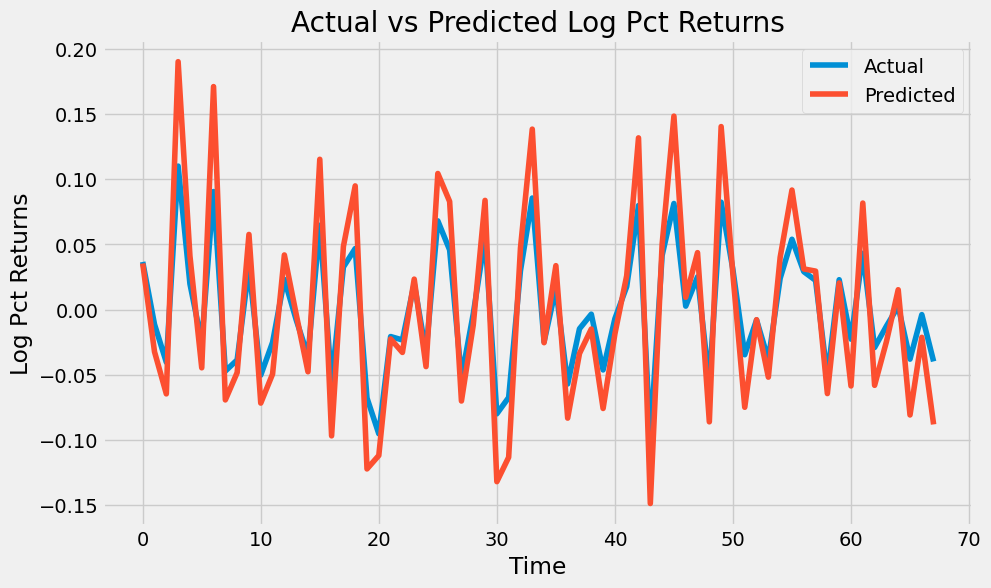

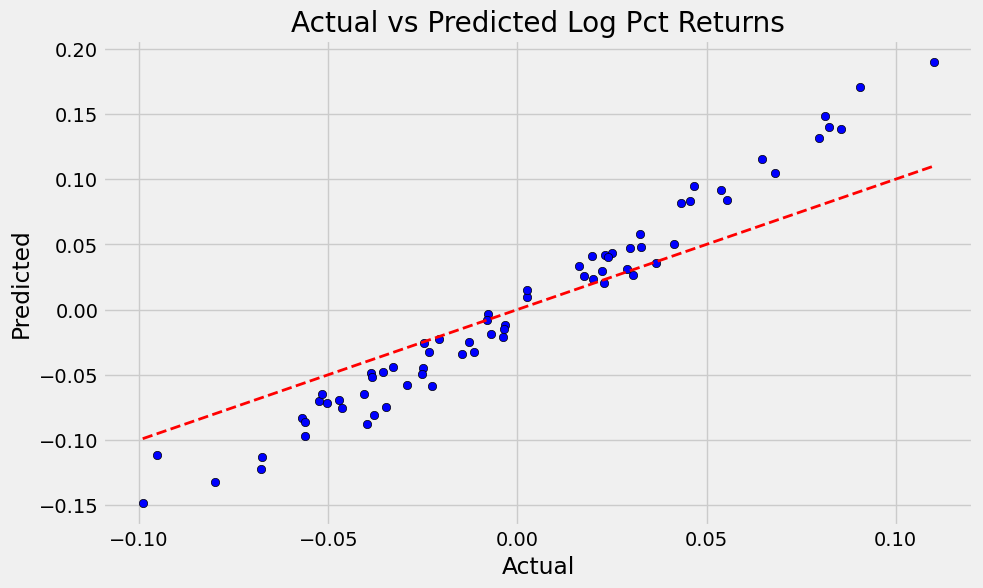

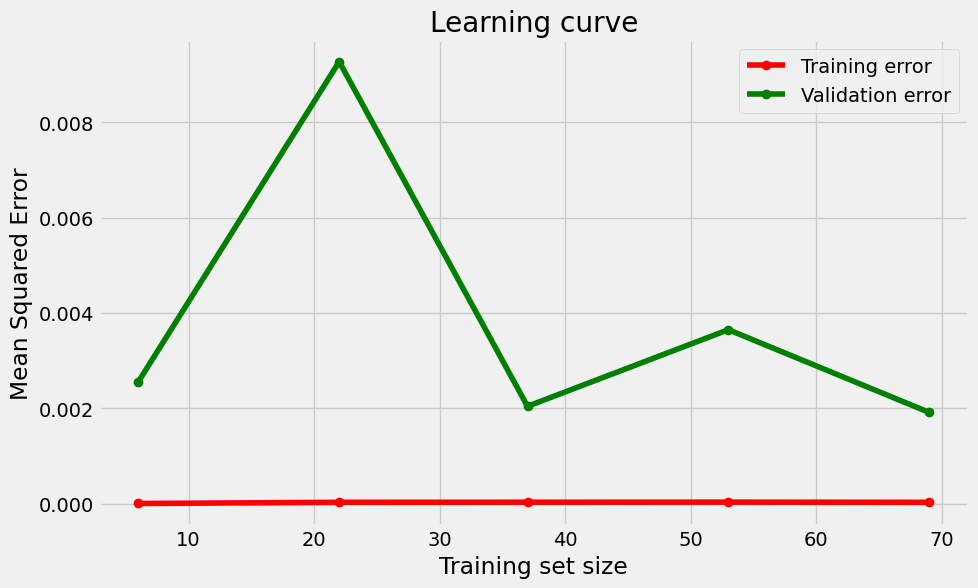

In [13]:
# Linear Regression
features = ['Volume_1', 'Open_1', 'High_1', 'Low_1','Adj Close_1',
            'Open_Close_Diff_1','High_Low_Diff_1', 'Gold_Adj_Close_1','USIndex_Adj_Close_1',
            'Volume_2', 'Open_2', 'High_2', 'Low_2','Adj Close_2',
            'Open_Close_Diff_2','High_Low_Diff_2', 'Gold_Adj_Close_2','USIndex_Adj_Close_2',
            'Volume_3', 'Open_3', 'High_3', 'Low_3','Adj Close_3',
            'High_Low_Diff_3', 'Gold_Adj_Close_3','USIndex_Adj_Close_3',
            'SMA_5_1', 'SMA_10_1', 'SMA_20_1', 'SMA_50_1',
            'EMA_50_1', 
            'MACD_Hist_1', 'BB_Upper_1', 'BB_Lower_1', '%K_1', '%D_1',
            'SMA_5_2', 'SMA_10_2', 'SMA_20_2', 'SMA_50_2',
            'EMA_50_2',   'MACD_Signal_2',
            'MACD_Hist_2', 'BB_Upper_2', 'BB_Lower_2', '%K_2', '%D_2'
            ]
X = df_coin[features].dropna()
y = df_coin['Log_Pct_Returns_1'][X.index]

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Initialize model
#model = LinearRegression()
alpha=0.01
model = Ridge(alpha=alpha)

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Initialize lists to store metrics
train_mse_scores = []
test_mse_scores = []
train_rmse_scores = []
test_rmse_scores = []
train_mae_scores = []
test_mae_scores = []
train_r2_scores = []
test_r2_scores = []
perm_imp_scores = []

# Perform cross-validation
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model
    model.fit(X_train, y_train)

    # Calculate permutation importance
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    perm_imp = result.importances_mean
    perm_imp_scores.append(perm_imp)
    
    # Predict on the test set
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate performance metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Append metrics to lists
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)
    train_mae_scores.append(train_mae)
    test_mae_scores.append(test_mae)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Calculate mean and standard deviation of the scores
mean_train_mse = np.mean(train_mse_scores)
std_train_mse = np.std(train_mse_scores)
mean_test_mse = np.mean(test_mse_scores)
std_test_mse = np.std(test_mse_scores)
mean_train_rmse = np.mean(train_rmse_scores)
std_train_rmse = np.std(train_rmse_scores)
mean_test_rmse = np.mean(test_rmse_scores)
std_test_rmse = np.std(test_rmse_scores)
mean_train_mae = np.mean(train_mae_scores)
std_train_mae = np.std(train_mae_scores)
mean_test_mae = np.mean(test_mae_scores)
std_test_mae = np.std(test_mae_scores)
mean_train_r2 = np.mean(train_r2_scores)
std_train_r2 = np.std(train_r2_scores)
mean_test_r2 = np.mean(test_r2_scores)
std_test_r2 = np.std(test_r2_scores)

# Calculate mean permutation importance across all folds
mean_perm_imp = np.mean(perm_imp_scores, axis=0)

# Print Results
print("Training MSE: {:.4f}".format(mean_train_mse))
print("Training MSE Std Dev: {:.4f}".format(std_train_mse))
print("Test MSE: {:.4f}".format(mean_test_mse))
print("Test MSE Std Dev: {:.4f}".format(std_test_mse))
print("Training RMSE: {:.4f}".format(mean_train_rmse))
print("Training RMSE Std Dev: {:.4f}".format(std_train_rmse))
print("Test RMSE: {:.4f}".format(mean_test_rmse))
print("Test RMSE Std Dev: {:.4f}".format(std_test_rmse))
print("Training MAE: {:.4f}".format(mean_train_mae))
print("Training MAE Std Dev: {:.4f}".format(std_train_mae))
print("Test MAE: {:.4f}".format(mean_test_mae))
print("Test MAE Std Dev: {:.4f}".format(std_test_mae))
print("Training R2: {:.4f}".format(mean_train_r2))
print("Training R2 Std Dev: {:.4f}".format(std_train_r2))
print("Test R2: {:.4f}".format(mean_test_r2))
print("Test R2 Std Dev: {:.4f}".format(std_test_r2))

# Visualize permutation importance
feature_names = X.columns
sorted_idx = mean_perm_imp.argsort()

plt.figure(figsize=(10, 8))
plt.barh(feature_names[sorted_idx], mean_perm_imp[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance of Features')
plt.show()

# Visualize model performance
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Log Pct Returns')
plt.title('Actual vs Predicted Log Pct Returns')
plt.legend()
plt.show()

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, c='blue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Log Pct Returns')
plt.show()

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(model, X_scaled, y, cv=tscv, scoring='neg_mean_squared_error')
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training set size')
plt.ylabel('Mean Squared Error')
plt.title('Learning curve')
plt.legend(loc='best')
plt.show()

In [14]:
# Defining features for models
features = ['Volume_1', 'Open_1', 'High_1', 'Low_1','Adj Close_1',
            'Open_Close_Diff_1','High_Low_Diff_1', 'Gold_Adj_Close_1','USIndex_Adj_Close_1',
            'Volume_2', 'Open_2', 'High_2', 'Low_2','Adj Close_2',
            'Open_Close_Diff_2','High_Low_Diff_2', 'Gold_Adj_Close_2','USIndex_Adj_Close_2',
            'Volume_3', 'Open_3', 'High_3', 'Low_3','Adj Close_3',
            'Open_Close_Diff_3','High_Low_Diff_3', 'Gold_Adj_Close_3','USIndex_Adj_Close_3',
            'SMA_5_1', 'SMA_10_1', 'SMA_20_1', 'SMA_50_1',
            'EMA_50_1', 'RSI_1', 'MACD_1', 'MACD_Signal_1',
            'MACD_Hist_1', 'BB_Upper_1', 'BB_Lower_1', '%K_1', '%D_1','ATR_1',
            'SMA_5_2', 'SMA_10_2', 'SMA_20_2', 'SMA_50_2',
            'EMA_50_2', 'RSI_2', 'MACD_2', 'MACD_Signal_2',
            'MACD_Hist_2', 'BB_Upper_2', 'BB_Lower_2', '%K_2', '%D_2', 'ATR_2'
            ]
X = df_coin[features].dropna()
y = df_coin['Log_Pct_Returns_1'][X.index]

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# Define models to evaluate
models = {
    "Lasso": Lasso(),
    "Linear": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boost": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(objective='reg:squarederror', alpha=0.01),
    "SVR": SVR(kernel='linear')
}

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Initialize dictionary to store results
results = {}

# Evaluate each model
for name, model in models.items():
    train_mse_scores, test_mse_scores = [], []
    train_rmse_scores, test_rmse_scores = [], []
    train_mae_scores, test_mae_scores = [], []
    train_r2_scores, test_r2_scores = [], []
    
    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        train_mse_scores.append(mean_squared_error(y_train, y_train_pred))
        test_mse_scores.append(mean_squared_error(y_test, y_test_pred))
        train_rmse_scores.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
        test_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
        train_mae_scores.append(mean_absolute_error(y_train, y_train_pred))
        test_mae_scores.append(mean_absolute_error(y_test, y_test_pred))
        train_r2_scores.append(r2_score(y_train, y_train_pred))
        test_r2_scores.append(r2_score(y_test, y_test_pred))
    
    results[name] = {
        "Training MSE": (np.mean(train_mse_scores), np.std(train_mse_scores)),
        "Test MSE": (np.mean(test_mse_scores), np.std(test_mse_scores)),
        "Training RMSE": (np.mean(train_rmse_scores), np.std(train_rmse_scores)),
        "Test RMSE": (np.mean(test_rmse_scores), np.std(test_rmse_scores)),
        "Training MAE": (np.mean(train_mae_scores), np.std(train_mae_scores)),
        "Test MAE": (np.mean(test_mae_scores), np.std(test_mae_scores)),
        "Training R2": (np.mean(train_r2_scores), np.std(train_r2_scores)),
        "Test R2": (np.mean(test_r2_scores), np.std(test_r2_scores))
    }

# Print results for each model
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric_name, (mean_value, std_dev) in metrics.items():
        print(f"{metric_name}: {mean_value:.4f} (Std Dev: {std_dev:.4f})")



Lasso:
Training MSE: 0.0029 (Std Dev: 0.0011)
Test MSE: 0.0035 (Std Dev: 0.0021)
Training RMSE: 0.0526 (Std Dev: 0.0111)
Test RMSE: 0.0567 (Std Dev: 0.0164)
Training MAE: 0.0397 (Std Dev: 0.0074)
Test MAE: 0.0445 (Std Dev: 0.0133)
Training R2: 0.0000 (Std Dev: 0.0000)
Test R2: -0.0168 (Std Dev: 0.0218)

Linear:
Training MSE: 0.0006 (Std Dev: 0.0004)
Test MSE: 0.0011 (Std Dev: 0.0012)
Training RMSE: 0.0212 (Std Dev: 0.0115)
Test RMSE: 0.0302 (Std Dev: 0.0153)
Training MAE: 0.0153 (Std Dev: 0.0082)
Test MAE: 0.0228 (Std Dev: 0.0119)
Training R2: 0.8348 (Std Dev: 0.0993)
Test R2: 0.7200 (Std Dev: 0.1359)

Random Forest:
Training MSE: 0.0002 (Std Dev: 0.0001)
Test MSE: 0.0017 (Std Dev: 0.0013)
Training RMSE: 0.0129 (Std Dev: 0.0026)
Test RMSE: 0.0388 (Std Dev: 0.0137)
Training MAE: 0.0085 (Std Dev: 0.0013)
Test MAE: 0.0275 (Std Dev: 0.0101)
Training R2: 0.9389 (Std Dev: 0.0080)
Test R2: 0.5281 (Std Dev: 0.1093)

Gradient Boost:
Training MSE: 0.0001 (Std Dev: 0.0001)
Test MSE: 0.0015 (Std 

#### Economic Indicators

In [15]:
# Fetch inflation rate data(Daily) from FRED using pandas_datareader
Inflation_df = pdr.get_data_fred('T5YIE', start=start_date, end=end_date)
Inflation_df.ffill()
Inflation_df.dropna(inplace=True)

# Fetch Federal fund rates data(Monthly) from FRED using pandas_datareader
Fedfunds_Mon = pdr.get_data_fred('FEDFUNDS', start=start_date, end=end_date)
Fedfunds_df = Fedfunds_Mon.resample('D').ffill()
Fedfunds_df.dropna(inplace=True)

# Fetch GDP growth data(Quarterly) from FRED using pandas_datareader
Gdp_Data_Quat = pdr.get_data_fred('GDPC1', start=start_date, end=end_date)
Gdp_Data_df = Gdp_Data_Quat.resample('D').ffill()
Gdp_Data_df.dropna(inplace=True)

# Fetch Unemployment rate data(Monthly) from FRED using pandas_datareader
Unemp_Data_Mon = pdr.get_data_fred('UNRATE', start=start_date, end=end_date)
Unemp_Data_df = Unemp_Data_Mon.resample('D').ffill()
Unemp_Data_df.dropna(inplace=True)

# Fetch University of Michigan Consumer Sentiment data(Monthly) from FRED using pandas_datareader
UM_Sent_Mon = pdr.get_data_fred('UMCSENT', start=start_date, end=end_date)
UM_Sent_df = UM_Sent_Mon.resample('D').ffill()
UM_Sent_df.dropna(inplace=True)

# Fetch Consumer Price Index data(Monthly) from FRED using pandas_datareader
Core_Cpi_Mon = pdr.get_data_fred('CPILFESL', start=start_date, end=end_date)
Core_Cpi_df = Core_Cpi_Mon.resample('D').ffill()
Core_Cpi_df.dropna(inplace=True)

# Fetch Commodity price data(Monthly) from FRED using pandas_datareader
Commpriceindex_Data_Mon = pdr.get_data_fred('PPIACO', start=start_date, end=end_date)
Commpriceindex_Data_df = Commpriceindex_Data_Mon.resample('D').ffill()
Commpriceindex_Data_df.dropna(inplace=True)

# Fetch M2 money supply from FRED using pandas_datareader
M2_Money_Supply_Mon = pdr.get_data_fred('WM2NS', start=start_date, end=end_date)
M2_Money_Supply_df = M2_Money_Supply_Mon.resample('D').ffill()
M2_Money_Supply_df.dropna(inplace=True)

# Setting 'Date' as index for economic data
Inflation_df.index = pd.to_datetime(Inflation_df.index)
Fedfunds_df.index = pd.to_datetime(Fedfunds_df.index)
Gdp_Data_df.index = pd.to_datetime(Gdp_Data_df.index)
Unemp_Data_df.index = pd.to_datetime(Unemp_Data_df.index)
UM_Sent_df.index = pd.to_datetime(UM_Sent_df.index)
Core_Cpi_Mon.index = pd.to_datetime(Core_Cpi_Mon.index)
Commpriceindex_Data_df.index = pd.to_datetime(Commpriceindex_Data_df.index)
M2_Money_Supply_df.index = pd.to_datetime(M2_Money_Supply_df.index)

# Merge main df with economic dataframes on 'Date'
merged_df = df_coin.join(Inflation_df, 
                    how='left').join(Fedfunds_df, 
                    how='left').join(Gdp_Data_df, 
                    how='left').join(Unemp_Data_df, 
                    how='left').join(UM_Sent_df,
                    how='left').join(Core_Cpi_df,
                    how='left').join(Commpriceindex_Data_df,
                    how='left').join(M2_Money_Supply_df,
                    how='left')
merged_df.dropna(inplace=True)
merged_df


,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close,Open_Close_Diff,High_Low_Diff,...,ATR_1,ATR_2,T5YIE,FEDFUNDS,GDPC1,UNRATE,UMCSENT,CPILFESL,PPIACO,WM2NS
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-01,251.089996,255.149994,240.529999,241.440002,241.440002,3611300,1775.900024,92.599998,9.649994,14.619995,...,9.779282,9.809281,2.49,0.10,21483.083,5.4,81.2,278.612,231.850,20327.8
2021-07-02,242.000000,246.800003,238.880005,240.720001,240.720001,2325000,1782.599976,92.230003,1.279999,7.919998,...,10.545710,9.779282,2.49,0.10,21483.083,5.4,81.2,278.612,231.850,20327.8
2021-07-06,243.000000,243.000000,234.020004,235.410004,235.410004,2212600,1793.500000,92.550003,7.589996,8.979996,...,9.979996,10.545710,2.48,0.10,21483.083,5.4,81.2,278.612,231.850,20547.0
2021-07-07,238.960007,252.990005,232.339996,251.970001,251.970001,4804400,1801.500000,92.639999,-13.009995,20.650009,...,10.039995,9.979996,2.43,0.10,21483.083,5.4,81.2,278.612,231.850,20547.0
2021-07-08,239.000000,246.600006,233.610001,244.289993,244.289993,4350000,1799.599976,92.360001,-5.289993,12.990005,...,10.914997,10.039995,2.38,0.10,21483.083,5.4,81.2,278.612,231.850,20547.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,169.770004,178.699997,167.899994,175.479996,175.479996,15788000,2057.100098,101.699997,-5.709991,10.800003,...,9.246428,9.339286,2.16,5.33,22679.255,3.7,69.7,313.209,249.866,20875.3
2023-12-26,174.800003,178.119995,169.050003,172.050003,172.050003,12544800,2058.199951,101.470001,2.750000,9.069992,...,9.122142,9.246428,2.17,5.33,22679.255,3.7,69.7,313.209,249.866,20901.5
2023-12-27,176.320007,186.970001,175.500000,185.240005,185.240005,15569900,2081.899902,100.989998,-8.919998,11.470001,...,9.149998,9.122142,2.12,5.33,22679.255,3.7,69.7,313.209,249.866,20901.5


In [16]:
# List of columns to shift
ecocolumns_to_shift = [
    'T5YIE', 'FEDFUNDS', 'GDPC1', 'UNRATE', 
    'UMCSENT', 'CPILFESL', 'PPIACO', 'WM2NS']

# Shift the columns
for column in ecocolumns_to_shift:
    merged_df[f'{column}_1'] = merged_df[column].shift(1)

merged_df.dropna(inplace=True)
merged_df

,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close,Open_Close_Diff,High_Low_Diff,...,PPIACO,WM2NS,T5YIE_1,FEDFUNDS_1,GDPC1_1,UNRATE_1,UMCSENT_1,CPILFESL_1,PPIACO_1,WM2NS_1
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-02,242.000000,246.800003,238.880005,240.720001,240.720001,2325000,1782.599976,92.230003,1.279999,7.919998,...,231.850,20327.8,2.49,0.10,21483.083,5.4,81.2,278.612,231.850,20327.8
2021-07-06,243.000000,243.000000,234.020004,235.410004,235.410004,2212600,1793.500000,92.550003,7.589996,8.979996,...,231.850,20547.0,2.49,0.10,21483.083,5.4,81.2,278.612,231.850,20327.8
2021-07-07,238.960007,252.990005,232.339996,251.970001,251.970001,4804400,1801.500000,92.639999,-13.009995,20.650009,...,231.850,20547.0,2.48,0.10,21483.083,5.4,81.2,278.612,231.850,20547.0
2021-07-08,239.000000,246.600006,233.610001,244.289993,244.289993,4350000,1799.599976,92.360001,-5.289993,12.990005,...,231.850,20547.0,2.43,0.10,21483.083,5.4,81.2,278.612,231.850,20547.0
2021-07-09,245.000000,256.989990,244.210007,253.880005,253.880005,4457400,1810.000000,92.129997,-8.880005,12.779984,...,231.850,20547.0,2.38,0.10,21483.083,5.4,81.2,278.612,231.850,20547.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,169.770004,178.699997,167.899994,175.479996,175.479996,15788000,2057.100098,101.699997,-5.709991,10.800003,...,249.866,20875.3,2.18,5.33,22679.255,3.7,69.7,313.209,249.866,20875.3
2023-12-26,174.800003,178.119995,169.050003,172.050003,172.050003,12544800,2058.199951,101.470001,2.750000,9.069992,...,249.866,20901.5,2.16,5.33,22679.255,3.7,69.7,313.209,249.866,20875.3
2023-12-27,176.320007,186.970001,175.500000,185.240005,185.240005,15569900,2081.899902,100.989998,-8.919998,11.470001,...,249.866,20901.5,2.17,5.33,22679.255,3.7,69.7,313.209,249.866,20901.5


Training MSE: 0.0006
Training MSE Std Dev: 0.0004
Test MSE: 0.0013
Test MSE Std Dev: 0.0014
Training RMSE: 0.0215
Training RMSE Std Dev: 0.0108
Test RMSE: 0.0321
Test RMSE Std Dev: 0.0176
Training MAE: 0.0152
Training MAE Std Dev: 0.0077
Test MAE: 0.0237
Test MAE Std Dev: 0.0129
Training R2: 0.8341
Training R2 Std Dev: 0.0959
Test R2: 0.7037
Test R2 Std Dev: 0.1597


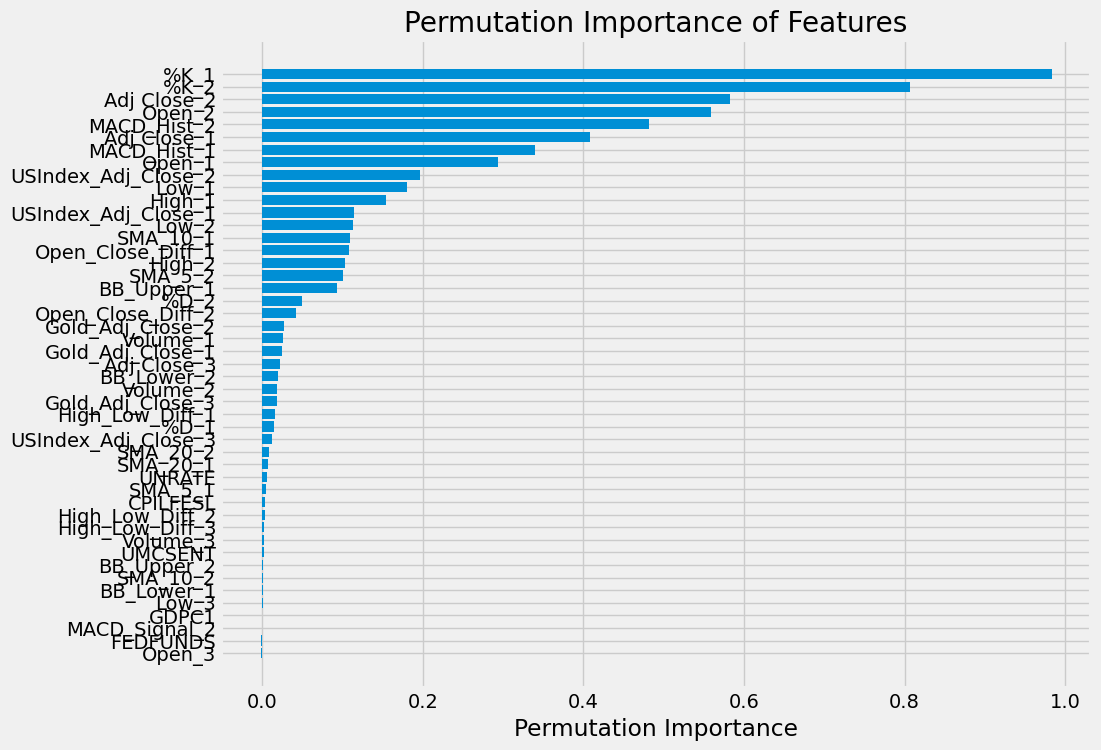

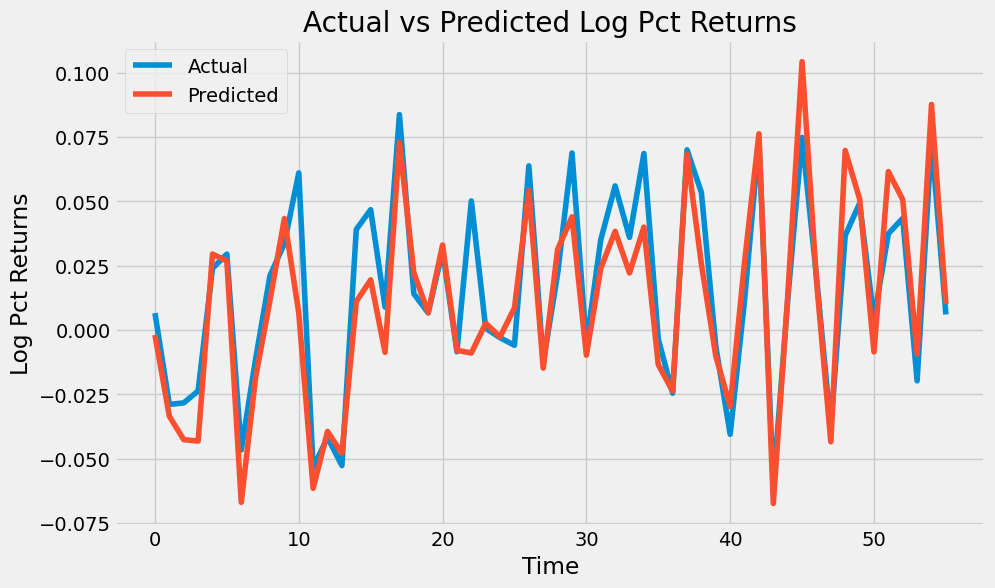

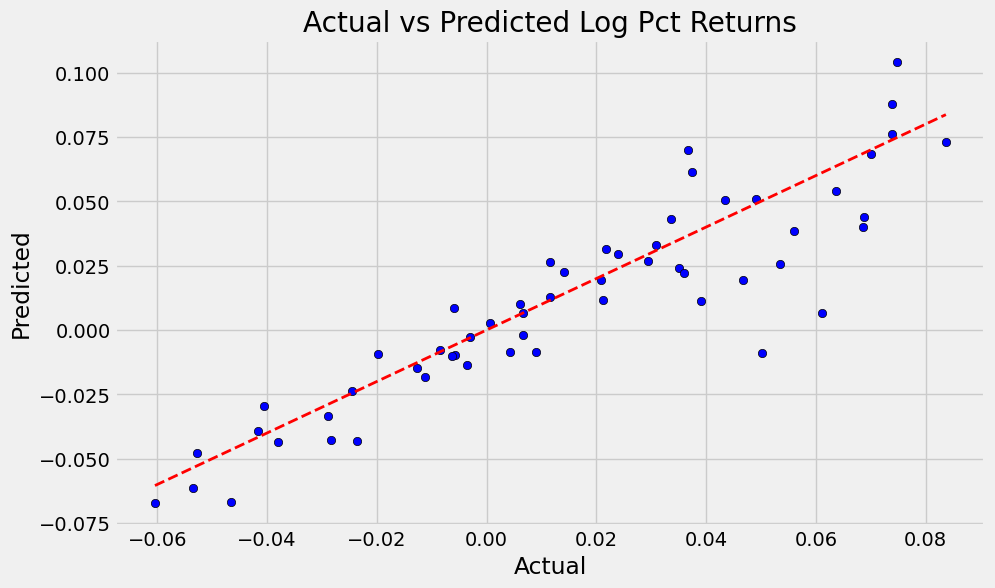

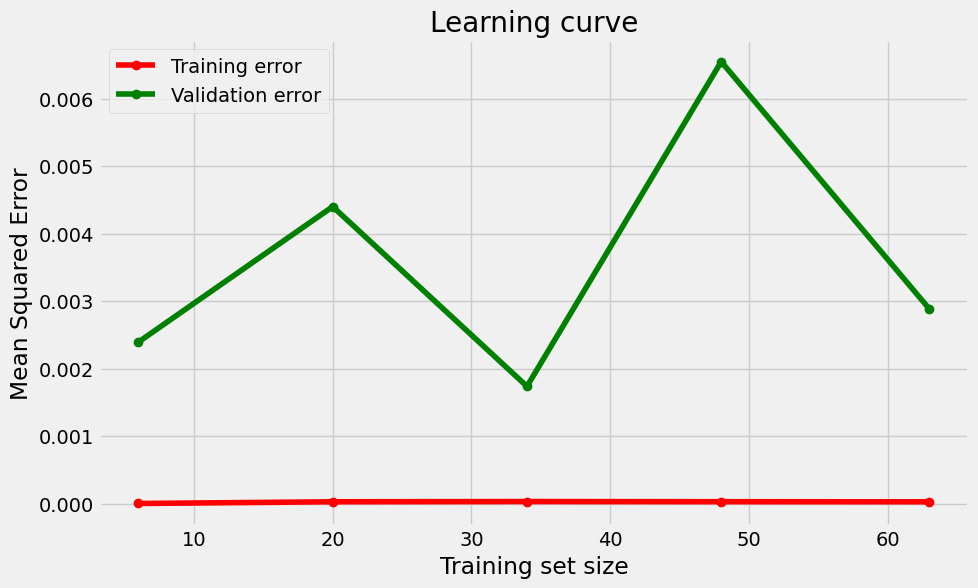

In [17]:
# Ridge Regression
features = ['Volume_1', 'Open_1', 'High_1', 'Low_1','Adj Close_1',
            'Open_Close_Diff_1','High_Low_Diff_1', 'Gold_Adj_Close_1','USIndex_Adj_Close_1',
            'Volume_2', 'Open_2', 'High_2', 'Low_2','Adj Close_2',
            'Open_Close_Diff_2','High_Low_Diff_2', 'Gold_Adj_Close_2','USIndex_Adj_Close_2',
            'Volume_3', 'Open_3', 'Low_3','Adj Close_3',
            'High_Low_Diff_3', 'Gold_Adj_Close_3','USIndex_Adj_Close_3',
            'SMA_5_1', 'SMA_10_1', 'SMA_20_1', 
            'MACD_Hist_1', 'BB_Upper_1', 'BB_Lower_1', '%K_1', '%D_1',
            'SMA_5_2', 'SMA_10_2', 'SMA_20_2',
              'MACD_Signal_2',
            'MACD_Hist_2', 'BB_Upper_2', 'BB_Lower_2', '%K_2', '%D_2',
            'FEDFUNDS', 'GDPC1', 'UNRATE', 
            'UMCSENT', 'CPILFESL'
            ]
X = merged_df[features].dropna()
y = merged_df['Log_Pct_Returns_1'][X.index]

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Initialize model
#model = LinearRegression()
alpha=0.01
model = Ridge(alpha=alpha)

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Initialize lists to store metrics
train_mse_scores = []
test_mse_scores = []
train_rmse_scores = []
test_rmse_scores = []
train_mae_scores = []
test_mae_scores = []
train_r2_scores = []
test_r2_scores = []
perm_imp_scores = []

# Perform cross-validation
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model
    model.fit(X_train, y_train)

    # Calculate permutation importance
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    perm_imp = result.importances_mean
    perm_imp_scores.append(perm_imp)
    
    # Predict on the test set
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate performance metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Append metrics to lists
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)
    train_mae_scores.append(train_mae)
    test_mae_scores.append(test_mae)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Calculate mean and standard deviation of the scores
mean_train_mse = np.mean(train_mse_scores)
std_train_mse = np.std(train_mse_scores)
mean_test_mse = np.mean(test_mse_scores)
std_test_mse = np.std(test_mse_scores)
mean_train_rmse = np.mean(train_rmse_scores)
std_train_rmse = np.std(train_rmse_scores)
mean_test_rmse = np.mean(test_rmse_scores)
std_test_rmse = np.std(test_rmse_scores)
mean_train_mae = np.mean(train_mae_scores)
std_train_mae = np.std(train_mae_scores)
mean_test_mae = np.mean(test_mae_scores)
std_test_mae = np.std(test_mae_scores)
mean_train_r2 = np.mean(train_r2_scores)
std_train_r2 = np.std(train_r2_scores)
mean_test_r2 = np.mean(test_r2_scores)
std_test_r2 = np.std(test_r2_scores)

# Calculate mean permutation importance across all folds
mean_perm_imp = np.mean(perm_imp_scores, axis=0)

# Print Results
print("Training MSE: {:.4f}".format(mean_train_mse))
print("Training MSE Std Dev: {:.4f}".format(std_train_mse))
print("Test MSE: {:.4f}".format(mean_test_mse))
print("Test MSE Std Dev: {:.4f}".format(std_test_mse))
print("Training RMSE: {:.4f}".format(mean_train_rmse))
print("Training RMSE Std Dev: {:.4f}".format(std_train_rmse))
print("Test RMSE: {:.4f}".format(mean_test_rmse))
print("Test RMSE Std Dev: {:.4f}".format(std_test_rmse))
print("Training MAE: {:.4f}".format(mean_train_mae))
print("Training MAE Std Dev: {:.4f}".format(std_train_mae))
print("Test MAE: {:.4f}".format(mean_test_mae))
print("Test MAE Std Dev: {:.4f}".format(std_test_mae))
print("Training R2: {:.4f}".format(mean_train_r2))
print("Training R2 Std Dev: {:.4f}".format(std_train_r2))
print("Test R2: {:.4f}".format(mean_test_r2))
print("Test R2 Std Dev: {:.4f}".format(std_test_r2))

# Visualize permutation importance
feature_names = X.columns
sorted_idx = mean_perm_imp.argsort()

plt.figure(figsize=(10, 8))
plt.barh(feature_names[sorted_idx], mean_perm_imp[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance of Features')
plt.show()

# Visualize model performance
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Log Pct Returns')
plt.title('Actual vs Predicted Log Pct Returns')
plt.legend()
plt.show()

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, c='blue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Log Pct Returns')
plt.show()

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(model, X_scaled, y, cv=tscv, scoring='neg_mean_squared_error')
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training set size')
plt.ylabel('Mean Squared Error')
plt.title('Learning curve')
plt.legend(loc='best')
plt.show()


Training MSE: 0.0006
Training MSE Std Dev: 0.0004
Test MSE: 0.0014
Test MSE Std Dev: 0.0016
Training RMSE: 0.0206
Training RMSE Std Dev: 0.0117
Test RMSE: 0.0319
Test RMSE Std Dev: 0.0196
Training MAE: 0.0149
Training MAE Std Dev: 0.0086
Test MAE: 0.0233
Test MAE Std Dev: 0.0141
Training R2: 0.8424
Training R2 Std Dev: 0.1002
Test R2: 0.7069
Test R2 Std Dev: 0.2021


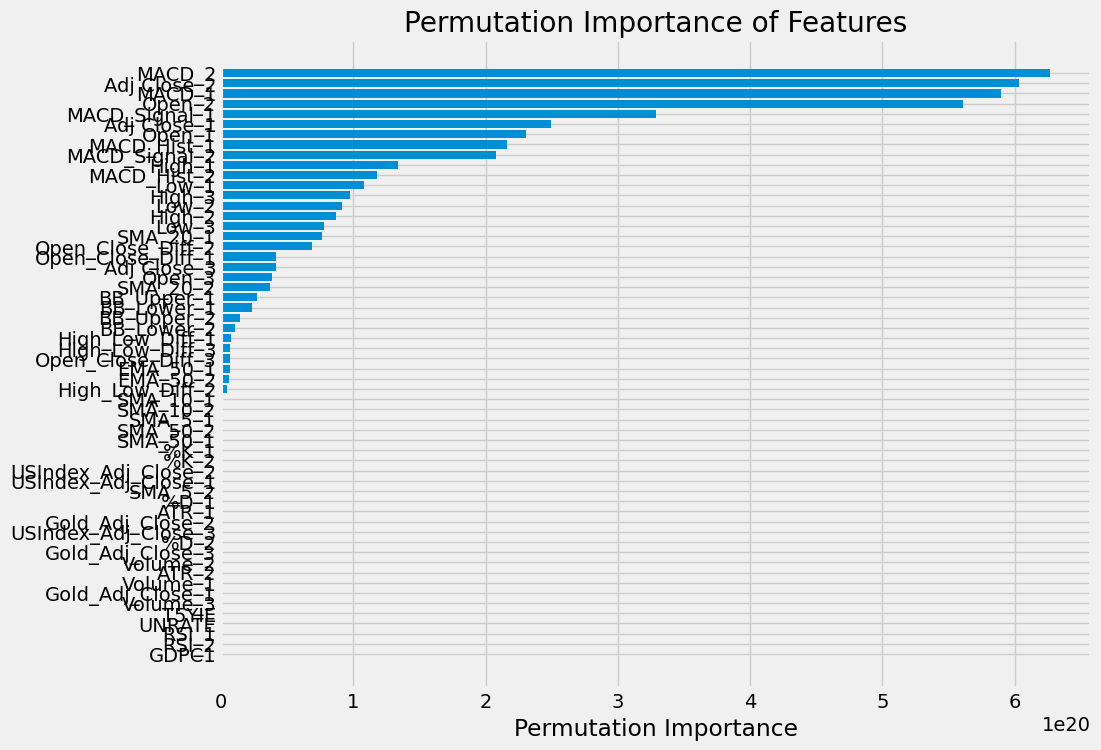

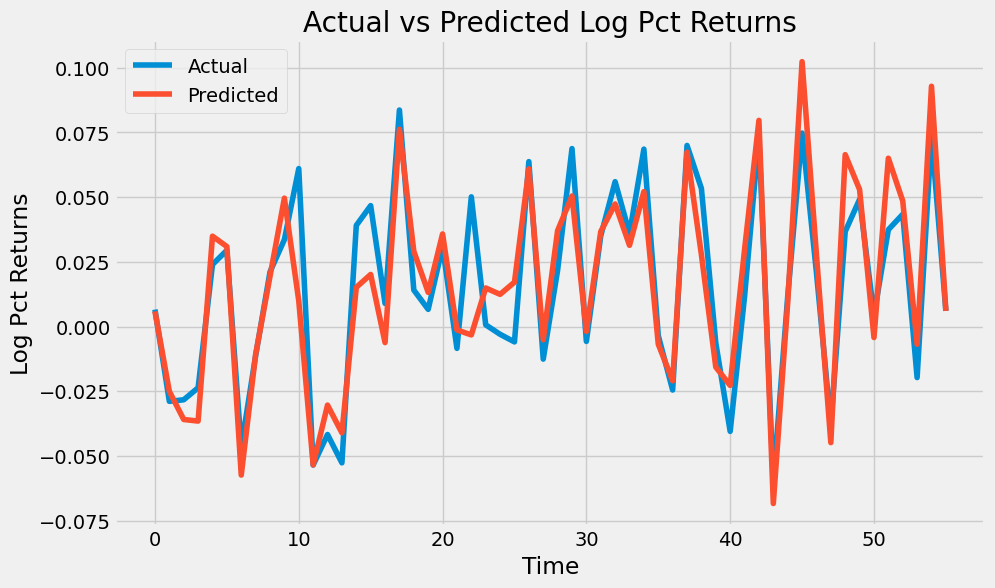

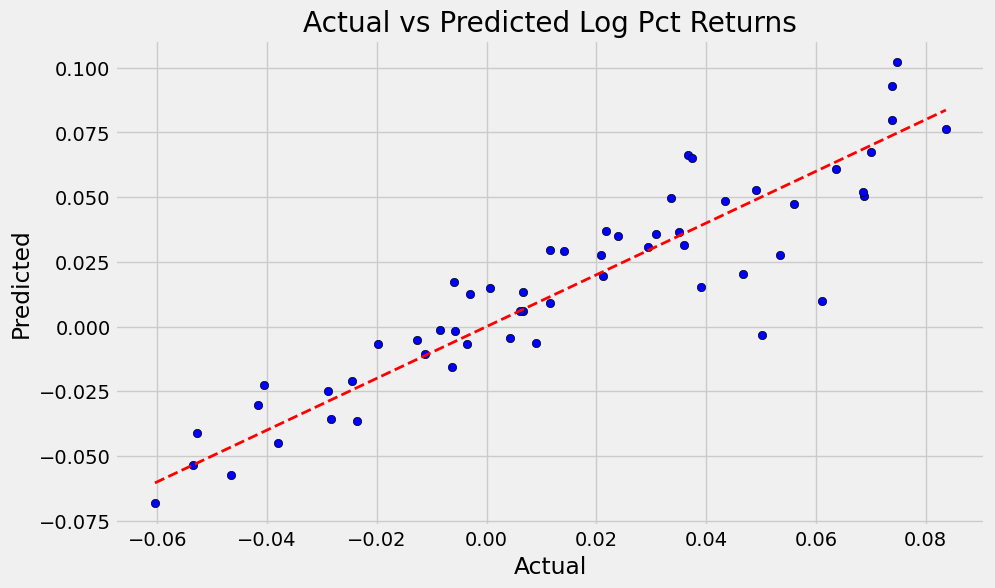

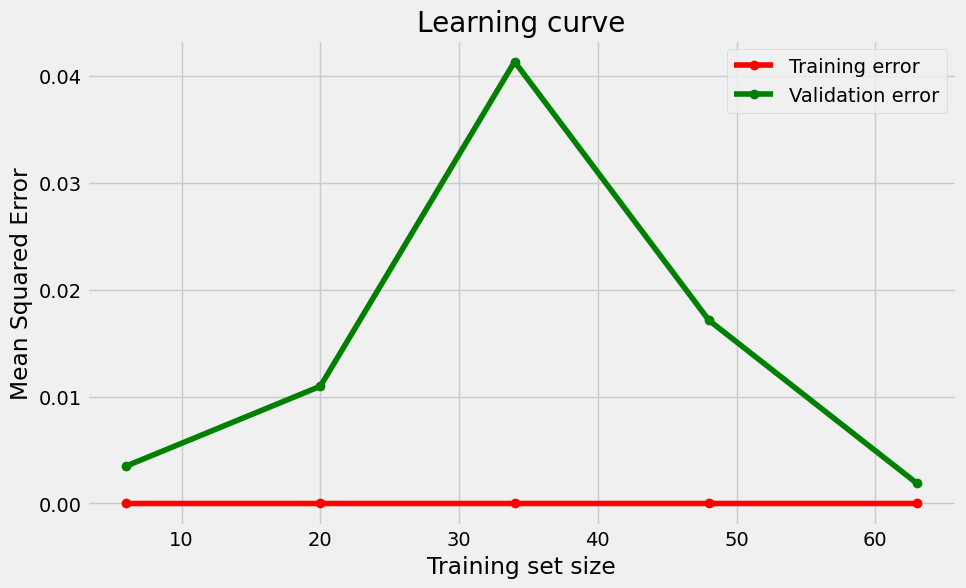

In [18]:
# Linear Regression
features = ['Volume_1', 'Open_1', 'High_1', 'Low_1','Adj Close_1',
            'Open_Close_Diff_1','High_Low_Diff_1', 'Gold_Adj_Close_1','USIndex_Adj_Close_1',
            'Volume_2', 'Open_2', 'High_2', 'Low_2','Adj Close_2',
            'Open_Close_Diff_2','High_Low_Diff_2', 'Gold_Adj_Close_2','USIndex_Adj_Close_2',
            'Volume_3', 'Open_3', 'High_3', 'Low_3','Adj Close_3',
            'Open_Close_Diff_3','High_Low_Diff_3', 'Gold_Adj_Close_3','USIndex_Adj_Close_3',
            'SMA_5_1', 'SMA_10_1', 'SMA_20_1', 'SMA_50_1',
            'EMA_50_1', 'RSI_1', 'MACD_1', 'MACD_Signal_1',
            'MACD_Hist_1', 'BB_Upper_1', 'BB_Lower_1', '%K_1', '%D_1','ATR_1',
            'SMA_5_2', 'SMA_10_2', 'SMA_20_2', 'SMA_50_2',
            'EMA_50_2', 'RSI_2', 'MACD_2', 'MACD_Signal_2',
            'MACD_Hist_2', 'BB_Upper_2', 'BB_Lower_2', '%K_2', '%D_2', 'ATR_2',
            'T5YIE',  'GDPC1', 'UNRATE'
            
            ]


X = merged_df[features].dropna()
y = merged_df['Log_Pct_Returns_1'][X.index]

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Initialize model
model = LinearRegression()

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Initialize lists to store metrics
train_mse_scores = []
test_mse_scores = []
train_rmse_scores = []
test_rmse_scores = []
train_mae_scores = []
test_mae_scores = []
train_r2_scores = []
test_r2_scores = []
perm_imp_scores = []

# Perform cross-validation
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model
    model.fit(X_train, y_train)

    # Calculate permutation importance
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    perm_imp = result.importances_mean
    perm_imp_scores.append(perm_imp)
    
    # Predict on the test set
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate performance metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Append metrics to lists
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)
    train_mae_scores.append(train_mae)
    test_mae_scores.append(test_mae)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Calculate mean and standard deviation of the scores
mean_train_mse = np.mean(train_mse_scores)
std_train_mse = np.std(train_mse_scores)
mean_test_mse = np.mean(test_mse_scores)
std_test_mse = np.std(test_mse_scores)
mean_train_rmse = np.mean(train_rmse_scores)
std_train_rmse = np.std(train_rmse_scores)
mean_test_rmse = np.mean(test_rmse_scores)
std_test_rmse = np.std(test_rmse_scores)
mean_train_mae = np.mean(train_mae_scores)
std_train_mae = np.std(train_mae_scores)
mean_test_mae = np.mean(test_mae_scores)
std_test_mae = np.std(test_mae_scores)
mean_train_r2 = np.mean(train_r2_scores)
std_train_r2 = np.std(train_r2_scores)
mean_test_r2 = np.mean(test_r2_scores)
std_test_r2 = np.std(test_r2_scores)

# Calculate mean permutation importance across all folds
mean_perm_imp = np.mean(perm_imp_scores, axis=0)

# Print Results
print("Training MSE: {:.4f}".format(mean_train_mse))
print("Training MSE Std Dev: {:.4f}".format(std_train_mse))
print("Test MSE: {:.4f}".format(mean_test_mse))
print("Test MSE Std Dev: {:.4f}".format(std_test_mse))
print("Training RMSE: {:.4f}".format(mean_train_rmse))
print("Training RMSE Std Dev: {:.4f}".format(std_train_rmse))
print("Test RMSE: {:.4f}".format(mean_test_rmse))
print("Test RMSE Std Dev: {:.4f}".format(std_test_rmse))
print("Training MAE: {:.4f}".format(mean_train_mae))
print("Training MAE Std Dev: {:.4f}".format(std_train_mae))
print("Test MAE: {:.4f}".format(mean_test_mae))
print("Test MAE Std Dev: {:.4f}".format(std_test_mae))
print("Training R2: {:.4f}".format(mean_train_r2))
print("Training R2 Std Dev: {:.4f}".format(std_train_r2))
print("Test R2: {:.4f}".format(mean_test_r2))
print("Test R2 Std Dev: {:.4f}".format(std_test_r2))

# Visualize permutation importance
feature_names = X.columns
sorted_idx = mean_perm_imp.argsort()

plt.figure(figsize=(10, 8))
plt.barh(feature_names[sorted_idx], mean_perm_imp[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance of Features')
plt.show()

# Visualize model performance
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Log Pct Returns')
plt.title('Actual vs Predicted Log Pct Returns')
plt.legend()
plt.show()

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, c='blue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Log Pct Returns')
plt.show()

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(model, X_scaled, y, cv=tscv, scoring='neg_mean_squared_error')
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training set size')
plt.ylabel('Mean Squared Error')
plt.title('Learning curve')
plt.legend(loc='best')
plt.show()

In [19]:
# Defining features for models
features = ['Volume_1', 'Open_1', 'High_1', 'Low_1','Adj Close_1',
            'Open_Close_Diff_1','High_Low_Diff_1', 'Gold_Adj_Close_1','USIndex_Adj_Close_1',
            'Volume_2', 'Open_2', 'High_2', 'Low_2','Adj Close_2',
            'Open_Close_Diff_2','High_Low_Diff_2', 'Gold_Adj_Close_2','USIndex_Adj_Close_2',
            'Volume_3', 'Open_3', 'High_3', 'Low_3','Adj Close_3',
            'Open_Close_Diff_3','High_Low_Diff_3', 'Gold_Adj_Close_3','USIndex_Adj_Close_3',
            'SMA_5_1', 'SMA_10_1', 'SMA_20_1', 'SMA_50_1',
            'EMA_50_1', 'RSI_1', 'MACD_1', 'MACD_Signal_1',
            'MACD_Hist_1', 'BB_Upper_1', 'BB_Lower_1', '%K_1', '%D_1','ATR_1',
            'SMA_5_2', 'SMA_10_2', 'SMA_20_2', 'SMA_50_2',
            'EMA_50_2', 'RSI_2', 'MACD_2', 'MACD_Signal_2',
            'MACD_Hist_2', 'BB_Upper_2', 'BB_Lower_2', '%K_2', '%D_2', 'ATR_2',
            'T5YIE', 'FEDFUNDS', 'GDPC1', 'UNRATE', 
            'UMCSENT', 'CPILFESL', 'PPIACO', 'WM2NS'
            ]
X = merged_df[features].dropna()
y = merged_df['Log_Pct_Returns_1'][X.index]

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# Define models to evaluate
models = {
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boost": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(objective='reg:squarederror'),
    "SVR": SVR(kernel='linear')
}

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Initialize dictionary to store results
results = {}

# Evaluate each model
for name, model in models.items():
    train_mse_scores, test_mse_scores = [], []
    train_rmse_scores, test_rmse_scores = [], []
    train_mae_scores, test_mae_scores = [], []
    train_r2_scores, test_r2_scores = [], []
    
    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        train_mse_scores.append(mean_squared_error(y_train, y_train_pred))
        test_mse_scores.append(mean_squared_error(y_test, y_test_pred))
        train_rmse_scores.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
        test_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
        train_mae_scores.append(mean_absolute_error(y_train, y_train_pred))
        test_mae_scores.append(mean_absolute_error(y_test, y_test_pred))
        train_r2_scores.append(r2_score(y_train, y_train_pred))
        test_r2_scores.append(r2_score(y_test, y_test_pred))
    
    results[name] = {
        "Training MSE": (np.mean(train_mse_scores), np.std(train_mse_scores)),
        "Test MSE": (np.mean(test_mse_scores), np.std(test_mse_scores)),
        "Training RMSE": (np.mean(train_rmse_scores), np.std(train_rmse_scores)),
        "Test RMSE": (np.mean(test_rmse_scores), np.std(test_rmse_scores)),
        "Training MAE": (np.mean(train_mae_scores), np.std(train_mae_scores)),
        "Test MAE": (np.mean(test_mae_scores), np.std(test_mae_scores)),
        "Training R2": (np.mean(train_r2_scores), np.std(train_r2_scores)),
        "Test R2": (np.mean(test_r2_scores), np.std(test_r2_scores))
    }

# Print results for each model
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric_name, (mean_value, std_dev) in metrics.items():
        print(f"{metric_name}: {mean_value:.4f} (Std Dev: {std_dev:.4f})")



Lasso:
Training MSE: 0.0029 (Std Dev: 0.0011)
Test MSE: 0.0036 (Std Dev: 0.0020)
Training RMSE: 0.0524 (Std Dev: 0.0113)
Test RMSE: 0.0579 (Std Dev: 0.0165)
Training MAE: 0.0394 (Std Dev: 0.0076)
Test MAE: 0.0449 (Std Dev: 0.0130)
Training R2: 0.0000 (Std Dev: 0.0000)
Test R2: -0.0408 (Std Dev: 0.0599)

Ridge:
Training MSE: 0.0009 (Std Dev: 0.0004)
Test MSE: 0.0017 (Std Dev: 0.0015)
Training RMSE: 0.0284 (Std Dev: 0.0084)
Test RMSE: 0.0370 (Std Dev: 0.0174)
Training MAE: 0.0192 (Std Dev: 0.0052)
Test MAE: 0.0271 (Std Dev: 0.0121)
Training R2: 0.7156 (Std Dev: 0.0594)
Test R2: 0.6021 (Std Dev: 0.1467)

Random Forest:
Training MSE: 0.0002 (Std Dev: 0.0001)
Test MSE: 0.0016 (Std Dev: 0.0010)
Training RMSE: 0.0131 (Std Dev: 0.0031)
Test RMSE: 0.0381 (Std Dev: 0.0131)
Training MAE: 0.0084 (Std Dev: 0.0013)
Test MAE: 0.0265 (Std Dev: 0.0081)
Training R2: 0.9376 (Std Dev: 0.0081)
Test R2: 0.5600 (Std Dev: 0.0862)

Gradient Boost:
Training MSE: 0.0001 (Std Dev: 0.0001)
Test MSE: 0.0014 (Std D

#### Financial Indicators

In [20]:
# Get the financial data of stock from Yahoo Finance
Coinbase = yf.Ticker(ticker)

quarterly_financials = Coinbase.quarterly_financials.T
quarterly_balance_sheet = Coinbase.quarterly_balance_sheet.T
quarterly_cash_Flow = Coinbase.quarterly_cashflow.T

# Convert indices to datetime
quarterly_financials.index = pd.to_datetime(quarterly_financials.index)
quarterly_balance_sheet.index = pd.to_datetime(quarterly_balance_sheet.index)
quarterly_cash_Flow.index = pd.to_datetime(quarterly_cash_Flow.index)

roa = quarterly_financials['Net Income'] / quarterly_balance_sheet['Total Assets']

roe = quarterly_financials['Net Income'] / (quarterly_balance_sheet['Total Assets'] - quarterly_balance_sheet['Total Liabilities Net Minority Interest'] - quarterly_balance_sheet['Total Non Current Liabilities Net Minority Interest'])

profit_margin = quarterly_financials['Net Income'] / quarterly_financials['Total Revenue']

Financial_Indicators = pd.DataFrame({
    'Return_on_Asset': roa,
    'Return_on_Equity': roe,
    'Profit_Margin': profit_margin
})
# Converting quarterly frequency to daily frequency
Daily_Financials = Financial_Indicators.resample('D').ffill()
Daily_Financials.dropna(inplace=True)
Daily_Financials

,Return_on_Asset,Return_on_Equity,Profit_Margin
2023-03-31,-0.000566,-0.035052,-0.102127
2023-04-01,-0.000566,-0.035052,-0.102127
2023-04-02,-0.000566,-0.035052,-0.102127
2023-04-03,-0.000566,-0.035052,-0.102127
2023-04-04,-0.000566,-0.035052,-0.102127
...,...,...,...
2024-03-27,0.001321,0.082999,0.286683
2024-03-28,0.001321,0.082999,0.286683
2024-03-29,0.001321,0.082999,0.286683
2024-03-30,0.001321,0.082999,0.286683


In [21]:
# List of columns to shift
fincolumns_to_shift = [
    'Return_on_Asset', 'Return_on_Equity', 'Profit_Margin']

# Shift the columns
for column in fincolumns_to_shift:
    Daily_Financials[f'{column}_1'] = Daily_Financials[column].shift(1)

Daily_Financials.dropna(inplace=True)
Daily_Financials

,Return_on_Asset,Return_on_Equity,Profit_Margin,Return_on_Asset_1,Return_on_Equity_1,Profit_Margin_1
2023-04-01,-0.000566,-0.035052,-0.102127,-0.000566,-0.035052,-0.102127
2023-04-02,-0.000566,-0.035052,-0.102127,-0.000566,-0.035052,-0.102127
2023-04-03,-0.000566,-0.035052,-0.102127,-0.000566,-0.035052,-0.102127
2023-04-04,-0.000566,-0.035052,-0.102127,-0.000566,-0.035052,-0.102127
2023-04-05,-0.000566,-0.035052,-0.102127,-0.000566,-0.035052,-0.102127
...,...,...,...,...,...,...
2024-03-27,0.001321,0.082999,0.286683,0.001321,0.082999,0.286683
2024-03-28,0.001321,0.082999,0.286683,0.001321,0.082999,0.286683
2024-03-29,0.001321,0.082999,0.286683,0.001321,0.082999,0.286683
2024-03-30,0.001321,0.082999,0.286683,0.001321,0.082999,0.286683


In [22]:
combined_df = pd.merge(merged_df, Daily_Financials, left_index=True, right_index=True, how='left')
combined_df.dropna(inplace=True)
combined_df

,Open,High,Low,Close,Adj Close,Volume,Gold_Adj_Close,USIndex_Adj_Close,Open_Close_Diff,High_Low_Diff,...,UMCSENT_1,CPILFESL_1,PPIACO_1,WM2NS_1,Return_on_Asset,Return_on_Equity,Profit_Margin,Return_on_Asset_1,Return_on_Equity_1,Profit_Margin_1
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-03,66.010002,68.330002,62.700001,63.610001,63.610001,14040300,1983.900024,102.089996,2.400002,5.630001,...,62.0,305.112,257.062,20894.3,-0.000566,-0.035052,-0.102127,-0.000566,-0.035052,-0.102127
2023-04-04,64.660004,65.400002,60.950001,62.540001,62.540001,11654400,2022.199951,101.589996,2.120003,4.450001,...,63.7,306.539,256.908,20950.9,-0.000566,-0.035052,-0.102127,-0.000566,-0.035052,-0.102127
2023-04-05,62.540001,63.049999,59.220001,60.779999,60.779999,10788900,2020.900024,101.849998,1.760002,3.829998,...,63.7,306.539,256.908,20950.9,-0.000566,-0.035052,-0.102127,-0.000566,-0.035052,-0.102127
2023-04-06,59.570000,62.740002,58.200001,61.439999,61.439999,11875200,2011.900024,101.820000,-1.869999,4.540001,...,63.7,306.539,256.908,20950.9,-0.000566,-0.035052,-0.102127,-0.000566,-0.035052,-0.102127
2023-04-10,61.369999,66.190002,59.660000,66.129997,66.129997,14391800,1989.099976,102.580002,-4.759998,6.530003,...,63.7,306.539,256.908,20950.9,-0.000566,-0.035052,-0.102127,-0.000566,-0.035052,-0.102127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,169.770004,178.699997,167.899994,175.479996,175.479996,15788000,2057.100098,101.699997,-5.709991,10.800003,...,69.7,313.209,249.866,20875.3,-0.000018,-0.000799,-0.00336,-0.000018,-0.000799,-0.00336
2023-12-26,174.800003,178.119995,169.050003,172.050003,172.050003,12544800,2058.199951,101.470001,2.750000,9.069992,...,69.7,313.209,249.866,20875.3,-0.000018,-0.000799,-0.00336,-0.000018,-0.000799,-0.00336
2023-12-27,176.320007,186.970001,175.500000,185.240005,185.240005,15569900,2081.899902,100.989998,-8.919998,11.470001,...,69.7,313.209,249.866,20901.5,-0.000018,-0.000799,-0.00336,-0.000018,-0.000799,-0.00336


Training MSE: 0.0001
Training MSE Std Dev: 0.0000
Test MSE: 0.0010
Test MSE Std Dev: 0.0009
Training RMSE: 0.0099
Training RMSE Std Dev: 0.0008
Test RMSE: 0.0286
Test RMSE Std Dev: 0.0141
Training MAE: 0.0074
Training MAE Std Dev: 0.0006
Test MAE: 0.0215
Test MAE Std Dev: 0.0098
Training R2: 0.9590
Training R2 Std Dev: 0.0026
Test R2: 0.4935
Test R2 Std Dev: 0.3344


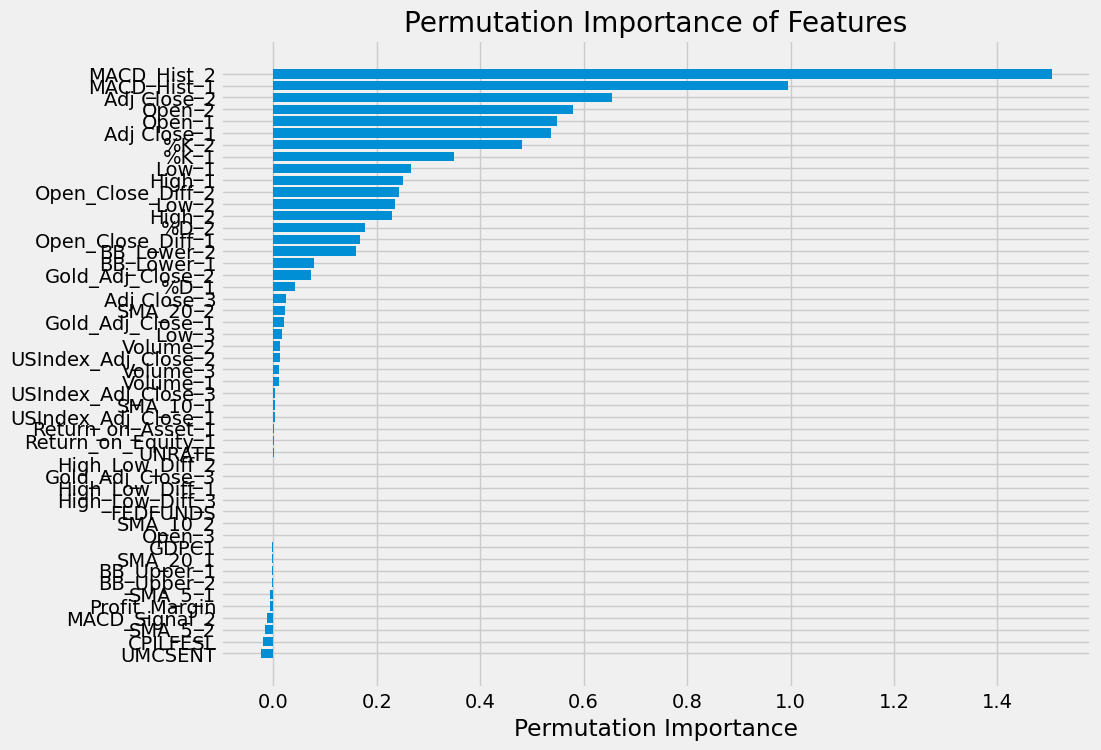

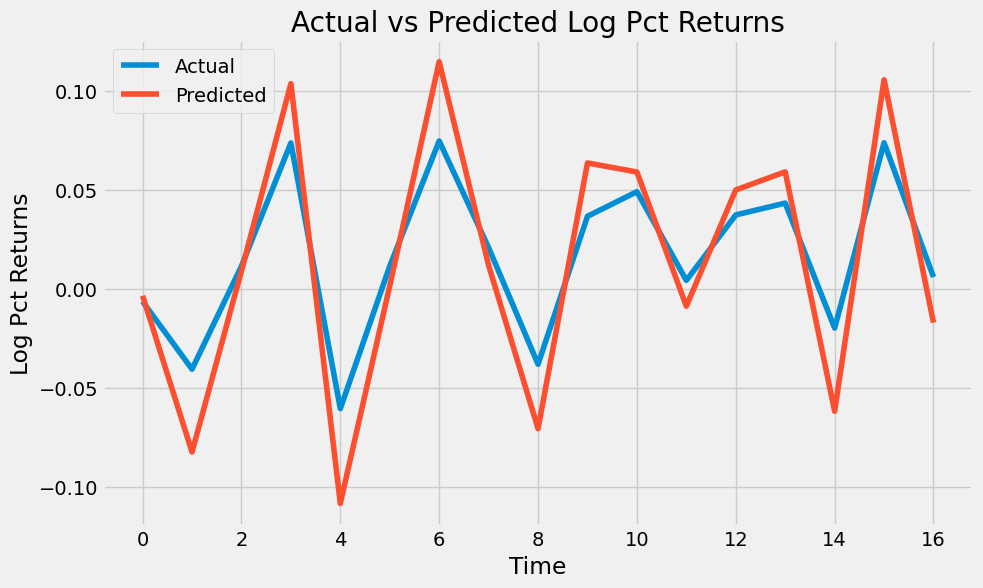

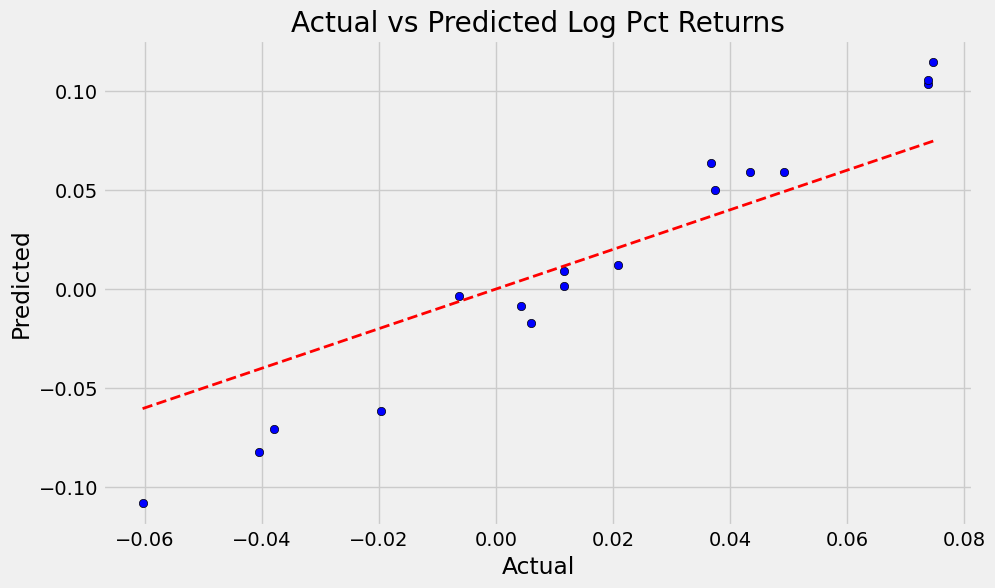

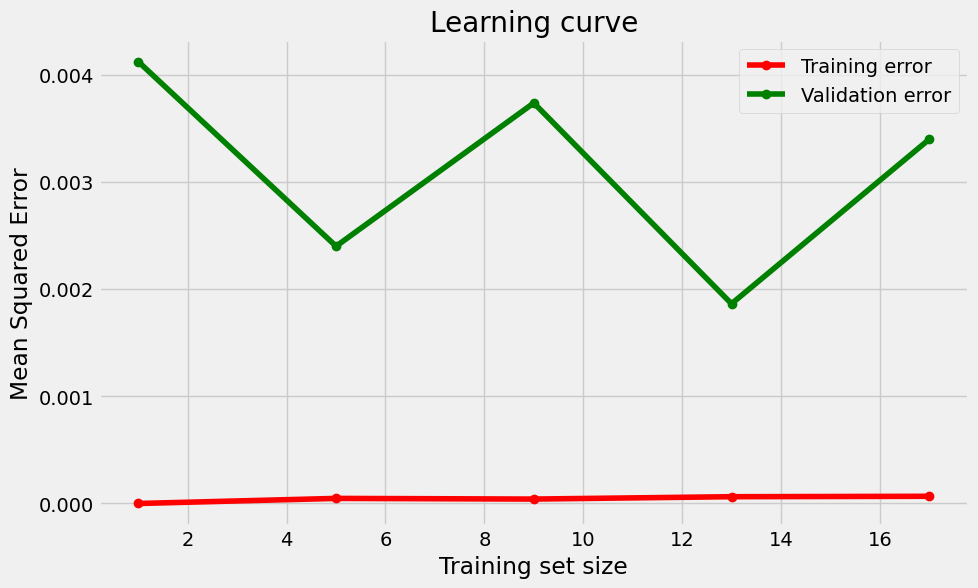

In [23]:
# Ridge Regression
features = ['Volume_1', 'Open_1', 'High_1', 'Low_1','Adj Close_1',
            'Open_Close_Diff_1','High_Low_Diff_1', 'Gold_Adj_Close_1','USIndex_Adj_Close_1',
            'Volume_2', 'Open_2', 'High_2', 'Low_2','Adj Close_2',
            'Open_Close_Diff_2','High_Low_Diff_2', 'Gold_Adj_Close_2','USIndex_Adj_Close_2',
            'Volume_3', 'Open_3', 'Low_3','Adj Close_3',
            'High_Low_Diff_3', 'Gold_Adj_Close_3','USIndex_Adj_Close_3',
            'SMA_5_1', 'SMA_10_1', 'SMA_20_1', 
            'MACD_Hist_1', 'BB_Upper_1', 'BB_Lower_1', '%K_1', '%D_1',
            'SMA_5_2', 'SMA_10_2', 'SMA_20_2',
              'MACD_Signal_2',
            'MACD_Hist_2', 'BB_Upper_2', 'BB_Lower_2', '%K_2', '%D_2',
            'FEDFUNDS', 'GDPC1', 'UNRATE', 
            'UMCSENT', 'CPILFESL',
            'Return_on_Asset_1', 'Return_on_Equity_1', 'Profit_Margin'

            ]
X = combined_df[features].dropna()
y = combined_df['Log_Pct_Returns_1'][X.index]

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Initialize model
#model = LinearRegression()
alpha=0.01
model = Ridge(alpha=alpha)

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Initialize lists to store metrics
train_mse_scores = []
test_mse_scores = []
train_rmse_scores = []
test_rmse_scores = []
train_mae_scores = []
test_mae_scores = []
train_r2_scores = []
test_r2_scores = []
perm_imp_scores = []

# Perform cross-validation
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model
    model.fit(X_train, y_train)

    # Calculate permutation importance
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    perm_imp = result.importances_mean
    perm_imp_scores.append(perm_imp)
    
    # Predict on the test set
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate performance metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Append metrics to lists
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)
    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)
    train_mae_scores.append(train_mae)
    test_mae_scores.append(test_mae)
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

# Calculate mean and standard deviation of the scores
mean_train_mse = np.mean(train_mse_scores)
std_train_mse = np.std(train_mse_scores)
mean_test_mse = np.mean(test_mse_scores)
std_test_mse = np.std(test_mse_scores)
mean_train_rmse = np.mean(train_rmse_scores)
std_train_rmse = np.std(train_rmse_scores)
mean_test_rmse = np.mean(test_rmse_scores)
std_test_rmse = np.std(test_rmse_scores)
mean_train_mae = np.mean(train_mae_scores)
std_train_mae = np.std(train_mae_scores)
mean_test_mae = np.mean(test_mae_scores)
std_test_mae = np.std(test_mae_scores)
mean_train_r2 = np.mean(train_r2_scores)
std_train_r2 = np.std(train_r2_scores)
mean_test_r2 = np.mean(test_r2_scores)
std_test_r2 = np.std(test_r2_scores)

# Calculate mean permutation importance across all folds
mean_perm_imp = np.mean(perm_imp_scores, axis=0)

# Print Results
print("Training MSE: {:.4f}".format(mean_train_mse))
print("Training MSE Std Dev: {:.4f}".format(std_train_mse))
print("Test MSE: {:.4f}".format(mean_test_mse))
print("Test MSE Std Dev: {:.4f}".format(std_test_mse))
print("Training RMSE: {:.4f}".format(mean_train_rmse))
print("Training RMSE Std Dev: {:.4f}".format(std_train_rmse))
print("Test RMSE: {:.4f}".format(mean_test_rmse))
print("Test RMSE Std Dev: {:.4f}".format(std_test_rmse))
print("Training MAE: {:.4f}".format(mean_train_mae))
print("Training MAE Std Dev: {:.4f}".format(std_train_mae))
print("Test MAE: {:.4f}".format(mean_test_mae))
print("Test MAE Std Dev: {:.4f}".format(std_test_mae))
print("Training R2: {:.4f}".format(mean_train_r2))
print("Training R2 Std Dev: {:.4f}".format(std_train_r2))
print("Test R2: {:.4f}".format(mean_test_r2))
print("Test R2 Std Dev: {:.4f}".format(std_test_r2))

# Visualize permutation importance
feature_names = X.columns
sorted_idx = mean_perm_imp.argsort()

plt.figure(figsize=(10, 8))
plt.barh(feature_names[sorted_idx], mean_perm_imp[sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance of Features')
plt.show()

# Visualize model performance
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Log Pct Returns')
plt.title('Actual vs Predicted Log Pct Returns')
plt.legend()
plt.show()

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, c='blue', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Log Pct Returns')
plt.show()

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(model, X_scaled, y, cv=tscv, scoring='neg_mean_squared_error')
train_scores_mean = -np.mean(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation error')
plt.xlabel('Training set size')
plt.ylabel('Mean Squared Error')
plt.title('Learning curve')
plt.legend(loc='best')
plt.show()


In [24]:
# Defining features for models
features = ['Volume_1', 'Open_1', 'High_1', 'Low_1','Adj Close_1',
            'Open_Close_Diff_1','High_Low_Diff_1', 'Gold_Adj_Close_1','USIndex_Adj_Close_1',
            'Volume_2', 'Open_2', 'High_2', 'Low_2','Adj Close_2',
            'Open_Close_Diff_2','High_Low_Diff_2', 'Gold_Adj_Close_2','USIndex_Adj_Close_2',
            'Volume_3', 'Open_3', 'High_3', 'Low_3','Adj Close_3',
            'Open_Close_Diff_3','High_Low_Diff_3', 'Gold_Adj_Close_3','USIndex_Adj_Close_3',
            'SMA_5_1', 'SMA_10_1', 'SMA_20_1', 'SMA_50_1',
            'EMA_50_1', 'RSI_1', 'MACD_1', 'MACD_Signal_1',
            'MACD_Hist_1', 'BB_Upper_1', 'BB_Lower_1', '%K_1', '%D_1','ATR_1',
            'SMA_5_2', 'SMA_10_2', 'SMA_20_2', 'SMA_50_2',
            'EMA_50_2', 'RSI_2', 'MACD_2', 'MACD_Signal_2',
            'MACD_Hist_2', 'BB_Upper_2', 'BB_Lower_2', '%K_2', '%D_2', 'ATR_2',
            'T5YIE', 'FEDFUNDS', 'GDPC1', 'UNRATE', 
            'UMCSENT', 'CPILFESL', 'PPIACO', 'WM2NS',
            'Return_on_Asset_1', 'Return_on_Equity_1', 'Profit_Margin'
            ]
X = combined_df[features].dropna()
y = combined_df['Log_Pct_Returns_1'][X.index]

# Apply MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# Define models to evaluate
models = {
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boost": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(objective='reg:squarederror'),
    "SVR": SVR(kernel='linear')
}

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)

# Initialize dictionary to store results
results = {}

# Evaluate each model
for name, model in models.items():
    train_mse_scores, test_mse_scores = [], []
    train_rmse_scores, test_rmse_scores = [], []
    train_mae_scores, test_mae_scores = [], []
    train_r2_scores, test_r2_scores = [], []
    
    for train_index, test_index in tscv.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        train_mse_scores.append(mean_squared_error(y_train, y_train_pred))
        test_mse_scores.append(mean_squared_error(y_test, y_test_pred))
        train_rmse_scores.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
        test_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
        train_mae_scores.append(mean_absolute_error(y_train, y_train_pred))
        test_mae_scores.append(mean_absolute_error(y_test, y_test_pred))
        train_r2_scores.append(r2_score(y_train, y_train_pred))
        test_r2_scores.append(r2_score(y_test, y_test_pred))
    
    results[name] = {
        "Training MSE": (np.mean(train_mse_scores), np.std(train_mse_scores)),
        "Test MSE": (np.mean(test_mse_scores), np.std(test_mse_scores)),
        "Training RMSE": (np.mean(train_rmse_scores), np.std(train_rmse_scores)),
        "Test RMSE": (np.mean(test_rmse_scores), np.std(test_rmse_scores)),
        "Training MAE": (np.mean(train_mae_scores), np.std(train_mae_scores)),
        "Test MAE": (np.mean(test_mae_scores), np.std(test_mae_scores)),
        "Training R2": (np.mean(train_r2_scores), np.std(train_r2_scores)),
        "Test R2": (np.mean(test_r2_scores), np.std(test_r2_scores))
    }

# Print results for each model
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric_name, (mean_value, std_dev) in metrics.items():
        print(f"{metric_name}: {mean_value:.4f} (Std Dev: {std_dev:.4f})")



Lasso:
Training MSE: 0.0024 (Std Dev: 0.0003)
Test MSE: 0.0022 (Std Dev: 0.0011)
Training RMSE: 0.0489 (Std Dev: 0.0032)
Test RMSE: 0.0450 (Std Dev: 0.0120)
Training MAE: 0.0369 (Std Dev: 0.0024)
Test MAE: 0.0343 (Std Dev: 0.0078)
Training R2: 0.0000 (Std Dev: 0.0000)
Test R2: -0.1858 (Std Dev: 0.2381)

Ridge:
Training MSE: 0.0008 (Std Dev: 0.0003)
Test MSE: 0.0012 (Std Dev: 0.0011)
Training RMSE: 0.0277 (Std Dev: 0.0045)
Test RMSE: 0.0301 (Std Dev: 0.0162)
Training MAE: 0.0203 (Std Dev: 0.0047)
Test MAE: 0.0226 (Std Dev: 0.0111)
Training R2: 0.6677 (Std Dev: 0.1199)
Test R2: 0.4275 (Std Dev: 0.4599)

Random Forest:
Training MSE: 0.0002 (Std Dev: 0.0000)
Test MSE: 0.0012 (Std Dev: 0.0009)
Training RMSE: 0.0144 (Std Dev: 0.0016)
Test RMSE: 0.0331 (Std Dev: 0.0118)
Training MAE: 0.0096 (Std Dev: 0.0016)
Test MAE: 0.0231 (Std Dev: 0.0071)
Training R2: 0.9123 (Std Dev: 0.0192)
Test R2: 0.3139 (Std Dev: 0.3230)

Gradient Boost:
Training MSE: 0.0000 (Std Dev: 0.0000)
Test MSE: 0.0014 (Std D